## Centro Federal de Educação Tecnológica Celso Suckow da Fonseca (CEFET-RJ)

## Programa de Pós Graduação em Ciência da Computação (PPCIC)

## Disciplina: Aprendizado de Máquinas

## Professor: Eduardo Bezerra

## Aluna: Cristiane Gea

## Trabalho 3

# 0. Inicialização do trabalho

## (a) Bibliotecas necessárias para o desenvolvimento do Trabalho 3

In [1]:
!pip install skorch

     |████████████████████████████████| 133kB 31.7MB/s 


In [2]:
%matplotlib inline

# Conexão do Google Colab com Google Drive
from google.colab import drive

# join one or more path components intelligently
from os.path import join

# Interface com o sistema operacional
import os

# Manipulação de dataframes
import pandas as pd

# Manipulação de dados tabulares
import numpy as np

# visualização de dados baseada no matplotlib
import seaborn as sns

# Esboço de gráficos
from matplotlib import pyplot as plt

# Leitura de dados de arquivos hdf5
import h5py

# Separação do conjunto de dados em treino e teste
from sklearn.model_selection import train_test_split

# Normalização das características
from sklearn.preprocessing import StandardScaler

# Classificador AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Gradient Boosting para classificação
from sklearn.ensemble import GradientBoostingClassifier

# Determinação dos conjuntos de treino e de validação cruzada para plotagem da curva de aprendizado
from sklearn.model_selection import learning_curve     
from sklearn.model_selection import ShuffleSplit    # Random permutation cross-validator

# Classificadores Bagging e Random Forest
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Classificador que implementa a votação de k-vizinhos mais próximos
from sklearn.neighbors import KNeighborsClassifier

# Avaliação do modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Busca exaustiva sobre valores de parâmetros especificados para um estimador (sintonização de hiperparâmetros)
from sklearn.model_selection import GridSearchCV

# Transformação das features
from sklearn.preprocessing import MinMaxScaler

# Classificador Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier

# Warning messages
import warnings

# Leitura de dados de arquivo .mat
from scipy.io import loadmat
import scipy.io as spio

# Otimização de funções
from scipy import optimize as opt
import torch.optim as optim

# Importação da biblioteca PyTorch
import torch

# Criação de modelos e preparação de variáveis
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Conversão de dados linearizados em tensores
from torch import Tensor

# Criação de Redes Neurais
import torch.nn as nn
import torch.nn.functional as F

# Sintonização de Hiperparâmetro ao Pytorch
from skorch import NeuralNetClassifier

# Criação de índices para divisão dos dados
from torch.utils.data.sampler import SubsetRandomSampler

# Funções relacionadas ao tempo
import time

# Exibição de uma imagem
from PIL import Image

# Carga das imagens de teste e visualização das classes originais
import torchvision

## (b) Preparação do ambiente (para utilização do Google Colab)

In [3]:
# Conexão entre o Google Colab ao Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Definição do path dos códigos e dados como diretório de trabalho atual
dir = '/content/drive/My Drive/Notebooks/CEFET/Aprendizado de Máquinas/Trabalho 3'
os.chdir(dir)

# 1. Aprendizado de Comitês (Ensemble Learning)

**Dados da questão**:

* Uma instituição financeira (fictícia) possui uma base de dados com o histórico de crediário oferecido aos seus clientes.

* Com base no histórico de crediário oferecido aos clientes, a instituição deseja investigar a criação de modelos de classificação para inferir se um novo clinete que submeteu uma requisição de empréstimo pagará ou não a dívida, caso o banco resolva realizar este empréstimo.

* Objetivo: Predizer se um novo cliente pagaria, ou não, uma dívida contraída, tendo como base as características desse novo cliente.

* Uma vez treinado, um modelo de classificação para o referido problema poderá inferir se um novo cliente irá, ou não, honrar um eventual empréstimo concedido a ele.

* O conjunto de dados a ser utilizado para o treinamento possui 1500 exemplos e contém dados relativos a créditos (empréstimos) concedidos aos clientes da instituição financeira.

* Os registros dos créditos concedidos aos clientes da instituição financeira estão contidos no arquivo `credtrain.txt`. Para cada cliente são definidos 11 atributos (variáveis, características). Além disso, a última coluna de cada exemplo informa se o cliente honrou, ou não o pagamento do empréstimo.

* A Tabela 1 contém a descrição dos atributos.

<img src="https://github.com/cristianegea/PPCIC/blob/main/Aprendizado%20de%20Máquinas/Trabalho%203/img/img1.png?raw=true" width="50%"/>

**Objetivos**:

* Realizar dois experimentos com algoritmos de *Boosting* e de *Bagging* para a criação de modelos de classificação para o problema supracitado.

* Para ambos os experimentos (com algoritmos de *Boosting* e de *Bagging*), apresentar os resultados (obtidos com a função `classification_report` do Scikit-Learn) para cada modelo de classificaçaõ sobre os dados contidos no arquivo `credtest.txt`.

Obs.: com relação aos hiperparâmetros do modelo, é possível utilizar os valores *default* ou os valores obtidos pela busca de hiperparâmetros.

**Aspectos conceituais**

Os comitês são abordagens para combinar várias tecnicas de aprendizado supervisionado em um modelo preditivo, objetivando a criação de uma coleção de preditores que, em conjunto, produzem uma predição melhor do que cada um separadamente.

O objetivo dos métodos de comitê é combinar diferentes classificadores em um mega classificador que possui melhor desempenho de generalização do que cada classificador individual isoladamente.

Em um comitê é importante que haja diversidade entre os componentes. Diante disso, um dos aspectos importantes para a compreensão do Aprendizado de Comitês é o princípio do voto marjoritário. Portanto, o voto majoritário compreende à seleção do rótulo da classe que foi predita pela a maioria dos classificadores (em outras palavras, que obteve mais de 50% dos votos).

A partir do conjunto de treinamento é iniciado o treinamento de $m$ classificadores distintos ($C_1, \dots, C_m$). Dependendo da técnica, o comitê pode ser construído a partir de diferentes algoritmos de classificação (como *decision trees*, *support vector machines*, regressão logística, entre outros). De forma alternativa, também é possível utilizar um mesmo algoritmo base de classificação e ajustando diferentes subconjuntos do conjunto de treinamento. A figura abaixo ilustra o conceito de uma abordagem geral de comitê, através do princípio do voto majortitário.

<img src="https://github.com/PacktPublishing/Python-Machine-Learning-Second-Edition/blob/master/Chapter07/images/07_02.png?raw=true" width="50%"/> {<small>**Fonte: Raschka & Mirjalili 2017**</small>}

A partir da imagem acima, é possível inferir o coneito geral de uma abordagem de comitê via voto majoritário. Para prever o rótulo da classe via voto majoritário, é realizada a combinação da predição dos rótulos das classes de cada classificador individual ($C_j$) e selecionado o rótulo da classe ($\hat{y}$) que recebe a maioria dos votos.

$$
\hat{y} = \text{mode} \left\{C_1(\mathbf{x}), C_2(\mathbf{x}), \dots, C_m(\mathbf{x}) \right\}
$$


## 1.1. Tratamento dos dados

**Importação e leitura dos dados**

In [6]:
# Definção dos nomes das variáveis (conforme a tabela contida no enunciado)
colnames = ['ESCT', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC',
            'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']

In [7]:
# Leitura dos dados de treino
arquivo = 'dados/credtrain.txt'
data_train = pd.read_csv(arquivo, sep='\t', header=None, names = colnames)

# Leitura dos dados de teste
arquivo = 'dados/credtest.txt'
data_test = pd.read_csv(arquivo, sep='\t', header=None, names = colnames)

**Inspeção dos dados**

In [8]:
# Inspeção da dimensão do dataset
print(data_train.shape, data_test.shape)

(1500, 12) (577, 12)


In [9]:
# Inspeção das primeiras linhas do conjunto de treinamento
data_train.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [10]:
# Inspeção das primeiras linhas do conjunto de treinamento
data_test.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,0,2,500,1,618,10,85,0,36,6,0,0
1,1,0,813,0,552,4,119,0,43,48,119,1
2,3,0,350,0,488,12,66,0,43,0,0,1
3,1,0,1530,0,381,1,398,0,28,48,0,1
4,0,0,688,1,396,10,60,0,49,72,0,1


**Tratamento da variável categória**

É importante observar que a variável ESCT (Estado Civil) é do tipo categórica, podendo assumir 4 valores diferentes (cada valor corresponde a um estado civil). Assim, diferentemente de NDEP (onde cada valor corresponde a uma quantidade de dependentes), na variável ESCT cada valor corresponde a uma categoria. Contudo, este fato pode trazer inconsistências na criação e treinamento de modelos.

Para mitigar este problema, uma alternativa é tranformar a variável ESCT em uma variável *dummy* (variável binária). Neste sentido, cada categoria da variável ESCT corresponderá a uma variável. Visto que há 4 possíveis categorias para a variável ESCT, obteremos 4 variáveis ESCT binárias.

Uma variável *dummy* é uma variável binária utilizadas para representar categorias. Neste sentido, em um caso de uma variável com 3 ou mais categorias, recomenda-se a criação de $n-1$ dummies. Diante disso, a variável ESCT será transformada em 4 "variantes dummy", onde o valor 1 corresponderá à ocorrência de determinada categoria e o valor 0 corresponderá à não ocorrência.

In [11]:
# Aplicação no conjunto de treinamento
data_train_new = pd.get_dummies(data = data_train, prefix='ESCT', columns=['ESCT'], drop_first=True)

    """
    pd.get_dummies: Convert categorical variable into dummy/indicator variables.
    """

# Inspeção das primeiras linhas
data_train_new.head()

,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE,ESCT_1,ESCT_2,ESCT_3
0,0,360,0,313,9,52,0,25,48,0,1,1,0,0
1,0,350,1,468,10,65,0,33,6,0,1,0,0,0
2,0,1100,0,829,9,125,0,56,48,0,1,0,0,0
3,0,3000,0,552,12,76,1,31,60,0,1,0,0,0
4,0,1000,0,809,12,111,0,24,7,0,1,1,0,0


In [12]:
# Aplicação no conjunto de teste
data_test_new = pd.get_dummies(data = data_test, prefix='ESCT', columns=['ESCT'], drop_first=True)

    """
    pd.get_dummies: Convert categorical variable into dummy/indicator variables
    """

# Inspeção das primeiras linhas
data_test_new.head()

,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE,ESCT_1,ESCT_2,ESCT_3
0,2,500,1,618,10,85,0,36,6,0,0,0,0,0
1,0,813,0,552,4,119,0,43,48,119,1,1,0,0
2,0,350,0,488,12,66,0,43,0,0,1,0,0,1
3,0,1530,0,381,1,398,0,28,48,0,1,1,0,0
4,0,688,1,396,10,60,0,49,72,0,1,0,0,0


**Separação do conjunto de dados em rótulo ($\mathrm{y}$) e features ($\mathrm{x}$)**

O rótulo ($\mathrm{y}$) corresponde ao vetor contendo a variável alvo (CLASSE), enquanto que features ($\mathrm{x}$) corresponde à matriz de dados.

In [13]:
# Transformação da variável alvo do conjunto de treinamento em vetor
y_train = np.array(data_train_new['CLASSE'])

# Inspeção das primeira linhas
y_train[:5]

array([1, 1, 1, 1, 1])

In [14]:
# Transformação da variável alvo do conjunto de teste em vetor
y_test = np.array(data_test_new['CLASSE'])

# Inspeção das primeira linhas
y_test[:5]

array([0, 1, 1, 1, 1])

In [15]:
# Transformação do conjunto de treinamento remanescente em matriz de dados
features_name_train = list(data_train_new.columns)               # Recuperação dos nomes das colunas
features_name_train.remove('CLASSE')                             # Remoção da variável "CLASSE"
X_train = np.array(data_train_new.loc[:, features_name_train])   # Transformação em matriz

# Inspeção da matriz resultante
X_train

array([[   0,  360,    0, ...,    1,    0,    0],
       [   0,  350,    1, ...,    0,    0,    0],
       [   0, 1100,    0, ...,    0,    0,    0],
       ...,
       [   0,  570,    0, ...,    0,    0,    0],
       [   0,  360,    0, ...,    0,    0,    0],
       [   4,  501,    1, ...,    0,    0,    0]])

In [16]:
# Transformação do conjunto de teste remanescente em matriz de dados
features_name_test = list(data_test_new.columns)               # Recuperação dos nomes das colunas
features_name_test.remove('CLASSE')                            # Remoção da variável "CLASSE"
X_test = np.array(data_test_new.loc[:, features_name_test])   # Transformação em matriz

# Inspeção da matriz resultante
X_test

array([[   2,  500,    1, ...,    0,    0,    0],
       [   0,  813,    0, ...,    1,    0,    0],
       [   0,  350,    0, ...,    0,    0,    1],
       ...,
       [   3, 1200,    0, ...,    0,    0,    0],
       [   0,  600,    0, ...,    1,    0,    0],
       [   0,  800,    1, ...,    0,    0,    0]])

**Observação importante**: Em virtude do fato de a classe `learning_curve` realizar por conta própria a divisão do dataset em treino e validação para comparação das curvas de aprendizado, não há necessidade de realizar a divisão do conjunto de treinamento nos subconjuntos de treino e de validação.

**Normalização das features**

De forma semelhante aos trabalhos anteriores, antes de prosseguir será realizada a normalização das características a fim de evitar problemas decorrentes à discrepância nas ordens de grandeza das features.

In [17]:
# Criação do objeto para a padronização das features
scaler = StandardScaler()

# Ajustamento do StandardScaler ao conjunto de dados de treino e padronização dos dados de treino
X_train_norm = scaler.fit_transform(X_train)

# Transformação dos dados de teste com os parâmetros ajustados a partir dos dados de treino
X_test_norm = scaler.transform(X_test)

In [18]:
# Dimensões dos datasets
print(X_train_norm.shape, X_test_norm.shape, y_train.shape, y_test.shape)

(1500, 13) (577, 13) (1500,) (577,)


## 1.2. Boosting

**Objetivos**:

* Criar modelos de classificação por meio dos indutores: `sklearn.ensemble.AdaBoostClassifier` e `sklearn.ensemble.GradientBoostingClassifier`.

* Para cada algoritmo de aprendizado, apresentar gráficos que plotam valores de acurácia (medidos nos conjuntos de treinamento e de validação( contra a quantidade de iterações de treinamento.

* Dividir os exemplos contidos no arquivo `credtrain.txt` em 2 subconjuntos (treinamento e validação), utilizando a proporção 80/20 para treinamento e validação, respectivamente.

**Aspectos conceituais**

Boosting refere-se ao método de comitê que pode combinar diversos classificadores fracos (aprendizes fracos) em um classificador forte (aprendiz forte). A ideia geral da maioria dos métodos é treinar sequencialmente os preditores, com cada um tentando prever corretamente seu predecessor. Assim, a cada iteração o algoritmo tenta adicionar novo modelo que seja melhor em regiões do espaço de features nas quais os modelos anteriores erraram.

O conceito-chave por trás do boosting é focar em amostras de treinamento que são difíceis de classificar (que recebem pesos maiores)_. Em outras palavras, o algoritmo permite que o aprendizado ocorra a partir das amostras classificadas incorretamente afim de melhorar o desempenho do conjunto. 

A partir de amostragem aleatória sem substituição, o boosting forma subconjuntos a partir do conjunto de dados de treinamento. Para melhor compreensão, este procedimento pode ser sintetizado pelas seguintes etapas:

* Formação do 1º subconjunto de treinamento aleatório $d_1$ (sem substituição) a partir do conjunto de treinamento $D$ para treinar o classificador fraco $C_1$.

* Formação do 2º subconjunto de treinamento aleatório $d_2$ (sem substituição) a partir do conjunto de treinamento e adição de 50% das amostras que foram classificadas erroneamente anteriormente para treinar o classificador fraco $C_2$.

* Localização da amostra de treinamento $d_3$ no conjunto de treinamento $D$, que $C_1$ e $C_2$ discordam, para treinar o classificador fraco $C_3$.

* Combinação dos classificadores fracos via votação majoritária.

Segundo Raschka & Mirjalili (2017), boosting pode levar a uma redução no viés e na variância, em comparação com modelos bagging. Contudo, na prática, algoritmos boosting como o AdaBoost também são conhecidos pela tendência de sobreajustar aos dados de treinamento.



### (a) Criação e treinamento de modelos

**AdaBoost**

O AdaBoost utiliza o conjunto de treinamento completo para treinar os classificadores fracos. Além disso, as amostras de treinamento são reponderadas em cada iteração para construção de um classificador forte, que aprende a partir dos erros cometidos anteriormente pelos classificadores fracos.

Este algoritmo constrói um comitê, $C(x)$, como uma combinação linear (soma ponderada) de $T$ classificadores fracos (aprendizes fracos).

$$
C(x) = \sum^T_{i = 1} \alpha_i c_i(x)
$$

onde $c_i(x)$ é um classificador fraco e $\alpha_i$ é o peso atribuído a cada classificador/aprendiz.

A figura abaixo sintetiza o conceito básico por trás do AdaBoost. 

<img src="https://github.com/PacktPublishing/Python-Machine-Learning-Second-Edition/blob/master/Chapter07/images/07_09.png?raw=true" width="40%" /> {<small>**Fonte: Raschka & Mirjalili 2017**</small>}

* A subfigura 1 mostra um conjunto de treinamento para uma tarefa de classificação binária com todas as amostras de treinamento igualmente ponderadas. Com base neste conjunto de treinamento, é realizada uma tentativa de classificar as amostras em 2 classes (triângulos e círculos).

* Na rodada seguinte (subfigura 2), são atribuídos pesos maiores às duas amostras que foram classificadas erroneamente na rodada anterior (cículos grandes), enquanto que as amostras que foram classificadas corretamente recebem pesos menores. Com isso, o foco da decisão residirá nas amostras de treinamento que receberam maiores pesos (amostras de treinamento que são vistas como difíceis de ser classificadas).

* Na rodada seguinte (subfigura 3) ocorre o processo semelhante. Assim, o comitê AdaBoot retratado na figura acima consiste de 3 rodadas de boosting.

* Na rodada final (subfigura 4), é realizada a combinação dos 3 classificadores fracos treinados sobre diferentes subconjuntos de treinamento reponderados por meior de um voto majoritário ponderado.

In [19]:
# Criação do indutor AdaBoost sem alteração de hiperparâmetros
adaboost = AdaBoostClassifier()

In [20]:
# Treinamento do modelo
adaboost.fit(X_train_norm, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

**Gradient Boosting**

Semelhante ao AdaBoost, o Gradient Boosting trabalha adicionando sequencialmente preditores para um comitê, onde cada um corrige seu predecessor. Contudo, em vez de ajustar os pesos da instância em cada iteração (como o AdaBoost), este método tenta ajustar o novo preditor aos erros residuais realizados pelo preditor anterior.

In [21]:
# Criação do indutor Gradient Boosting sem alteração de hiperparâmetros
gradientboost = GradientBoostingClassifier()

In [22]:
# Treinamento do modelo
gradientboost.fit(X_train_norm, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### (b) Curvas de aprendizado

As curvas de aprendizado visualizam o desempenho de um modelo sobre o conjunto de treinamento e durante a validação cruzada, a medida que o número de observações no conjuntode treinamento aumenta. Elas são comumente utilizadas para determinar se os algoritmos de aprendizado poderiam se beneficiar com a coleta de dados de treinamento adicionais.

**Definição do critério de validação**

In [23]:
# Escolha aleatória de 20% do conjunto para validação para cada iteração
cv = ShuffleSplit(test_size = 0.2, random_state = 31)

**Curva de Aprendizado do Modelo AdaBoost**

In [24]:
# Aplicação da função para comparação dos resultados de validação e treino
_, acc_treino, acc_val = learning_curve(adaboost,
                                        X_train_norm,
                                        y_train,
                                        scoring = 'accuracy',
                                        random_state = 31,
                                        cv = cv)

In [25]:
# Cálculo dos scores baseado na média das rodadas
acc_treino_adaboost = np.mean(acc_treino, axis=1)
acc_val_adaboost = np.mean(acc_val, axis=1)

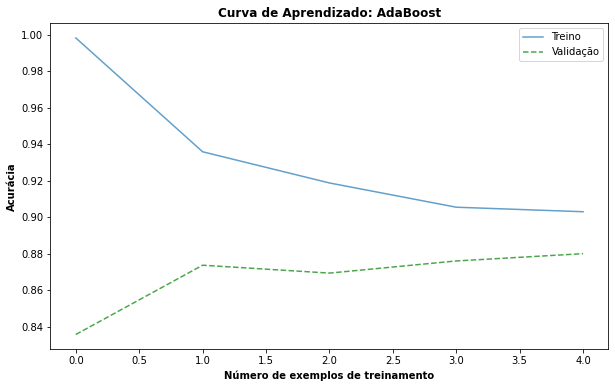

In [26]:
# Gráfico da curva de aprendizado
plt.figure(figsize = (10,6))
plt.plot(acc_treino_adaboost, alpha=0.7)         # Treino
plt.plot(acc_val_adaboost, 'g--', alpha=0.7)     # Validação

# Rótulos e legendas dos gráficos
plt.xlabel('Número de exemplos de treinamento', fontweight='bold')
plt.ylabel('Acurácia', fontweight='bold')
plt.title('Curva de Aprendizado: AdaBoost', fontweight='bold')
plt.legend(['Treino', 'Validação'])

Pelo gráfico acima, é possível observar que a partir de 1 exemplo de treinamento o algoritmo está começando a se ajustar aos exemplos do conjunto de treinamento e de validação. Diante disso, é possível observar que a acurácia do modelo com os dados de treinamento apresenta um tendência descendente e a acurácia do modelo com os dados de validação apresenta uma tendência ascendente. Em outras palavras, o gráfico acima mostra que à medida que o número de exemplos de treinamento aumenta maior tende a ser o erro de treinamento e menor tende a ser o erro de validação. Diante disso, é possível observar um possível problema de *underfitting*. 

**Curva de Aprendizado do Modelo Gradient Boosting**

In [27]:
#Aplicação da função para comparação dos resultados de validação e treino
_, acc_treino, acc_val = learning_curve(gradientboost,
                                        X_train_norm,
                                        y_train,
                                        scoring = 'accuracy',
                                        random_state = 31,
                                        cv = cv)

In [28]:
#Cálculo dos scores baseado na média das rodadas
acc_treino_gradientboost = np.mean(acc_treino, axis=1)
acc_val_gradientboost = np.mean(acc_val, axis=1)

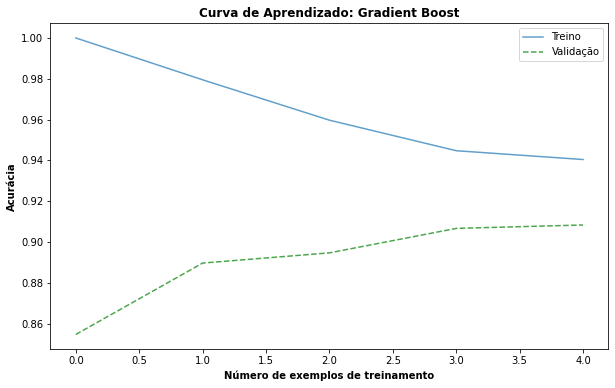

In [29]:
# Gráfico da curva de aprendizado
plt.figure(figsize = (10,6))
plt.plot(acc_treino_gradientboost, alpha=0.7)         # Treino
plt.plot(acc_val_gradientboost, 'g--', alpha=0.7)     # Validação

# Rótulos e legendas dos gráficos
plt.xlabel('Número de exemplos de treinamento', fontweight='bold')
plt.ylabel('Acurácia', fontweight='bold')
plt.title('Curva de Aprendizado: Gradient Boost', fontweight='bold')
plt.legend(['Treino', 'Validação'])

Pelo gráfico acima, é possível observar que a partir de 1 exemplo de treinamento o algoritmo está começando a se ajustar aos exemplos do conjunto de treinamento e de validação. Diante disso, é possível observar que a acurácia do modelo com os dados de treinamento apresenta um tendência descendente e a acurácia do modelo com os dados de validação apresenta uma tendência ascendente. Em outras palavras, o gráfico acima mostra que à medida que o número de exemplos de treinamento aumenta maior tende a ser o erro de treinamento e menor tende a ser o erro de validação. Diante disso, é possível observar um possível problema de *underfitting*. 

**Comparativo entre as curvas de aprendizado**

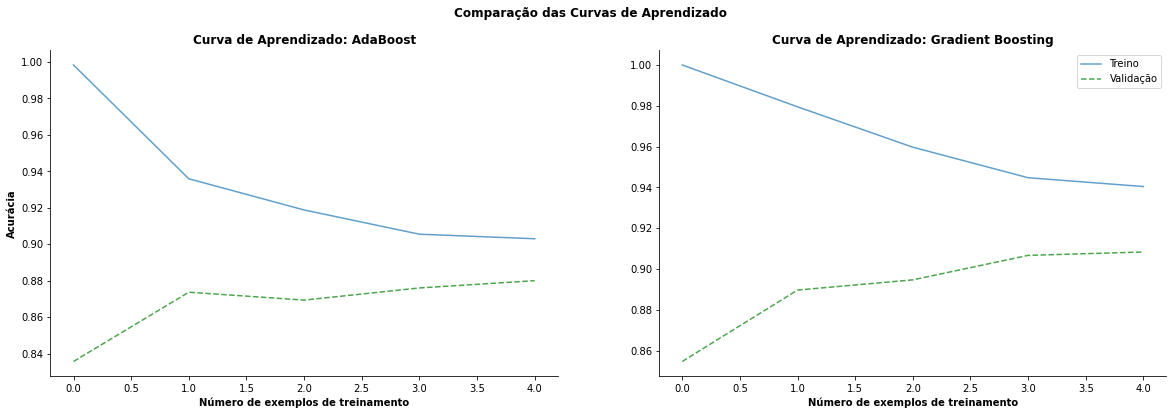

In [30]:
fig = plt.figure(figsize=(20,6))
fig.suptitle('Comparação das Curvas de Aprendizado', fontweight='bold')

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Curva de aprendizado AdaBoost
ax1.plot(acc_treino_adaboost, alpha=0.7)         # Treino
ax1.plot(acc_val_adaboost, 'g--', alpha=0.7)     # Validação

# Rótulos e legendas dos gráficos
ax1.set_xlabel('Número de exemplos de treinamento', fontweight='bold')
ax1.set_ylabel('Acurácia', fontweight='bold')
ax1.set_title('Curva de Aprendizado: AdaBoost', fontweight='bold')


# Curva de aprendizado Gradient Boosting
ax2.plot(acc_treino_gradientboost, alpha=0.7)         # Treino
ax2.plot(acc_val_gradientboost, 'g--', alpha=0.7)     # Validação

# Rótulos e legendas dos gráficos
ax2.legend(['Treino', 'Validação'], loc='upper right')
ax2.set_xlabel('Número de exemplos de treinamento', fontweight='bold')
ax2.set_title('Curva de Aprendizado: Gradient Boosting', fontweight='bold')

# Ajustes visuais finais
sns.despine()

Conforme discutido anteriormente para cada caso isoladamente, ambos os casos indicam um possível problema de *underfitting*.

Um outro ponto que vale a pena mencionar são as diferenças identificadas em cada caso:

* Enquanto que no AdaBoost é possível visualizar uma convergência entre as curvas de treinamento e de validação, no Gradient Boost as mesmas encontram-se mais distantes.

* O comportamento das curvas de treinamento e de validação apresentam trajetórias mais suavizadas para o Gradient Boost do que para o AdaBoost.

* O patamar de acurácia das curvas de aprendizado para Gradient Boost permaneceu, em média, superior ao das curvas de aprendizado para AdaBoost.

### (c) Predição e Avaliação dos Modelos

**AdaBoost**

In [31]:
# Uso dos modelos para predição
y_pred_adaboost = adaboost.predict(X_test_norm)

In [32]:
# Avaliação do modelo
print(classification_report(y_test, y_pred_adaboost))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       306
           1       0.88      0.82      0.85       271

    accuracy                           0.87       577
   macro avg       0.87      0.86      0.87       577
weighted avg       0.87      0.87      0.87       577



**Gradient Boosting**

In [33]:
# Uso dos modelos para predição
y_pred_gradientboost = gradientboost.predict(X_test_norm)

In [34]:
# Avaliação do modelo
print(classification_report(y_test, y_pred_gradientboost))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       306
           1       0.96      0.83      0.89       271

    accuracy                           0.90       577
   macro avg       0.91      0.90      0.90       577
weighted avg       0.91      0.90      0.90       577



**Comparativo de desempenho entre os modelos**

|     Modelos     | Acurácia |  F1 (classe 0) |F1 (classe 1) |
| :-------------: | :------: |:-------------: |:--------: |
|    AdaBoost     |   0.87   |      0.88      |      0.85       |
| Gradient Boost  |   0.90   |      0.91      |      0.89       |

Pelo comparativo acima é possível inferir que o modelo Gradient Boost apresentou melhor desempenho preditivo, em comparação ao modelo AdaBoost. Dado que as curvas de aprendizado do modelo Gradient Boost apresentaram comportamento mais estável e em patamar de acurácia maior, era esperado que o mesmo apresentasse um desempenho preditivo superior (em comparação ao modelo AdaBoost). 

## 1.3. Bagging

**Objetivos**:

* Usando os indutores `sklearn.ensemble.BaggingClassifier` e `sklearn.ensemble.RandomForestClassifier` ajustar novos modelos sobre o conjunto de treinamento fornecido.

* Normalizar os dados (algumas variáveis preditoras no conjunto de dados possuem ordens de grandeza diferentes).

* Transformar as variáveis discretas nominais (o algoritmo KNN não trabalha com atributos desse tipo).

**Aspectos conceituais**

Bagging é uma técnica de aprendizado de comitês que, em vez que utilizar o mesmo conjunto de treinamento para ajustamentos dos classificadores individuais no comitê, são definidas amostras bootstrap (amostras aleatórias com reposição) a partir do conjunto de treinamento inicial. Diante disso, a diversidade é obtida com a utilização de diferentes subconjuntos de dados aleatoriamente criados com reposição.

O conceito de bagging pode ser sintetizado pela figura abaixo:

<img src="https://github.com/PacktPublishing/Python-Machine-Learning-Second-Edition/blob/master/Chapter07/images/07_06.png?raw=true" width="50%"/> {<small>**Fonte: Raschka & Mirjalili 2017**</small>}

Considerando a existência de diferentes instâncias de treinamento (denotados pelos índices 1-7), que correspondem a amostras aleatórias realizadas com reposição em cada rodada do bagging. Assim, cada amostra bootstrap é utilizada para ajustar um classificador $C_j$.

Conforme figura abaixo, cada classificador recebe um subconjunto aleatório de amostras extraído do conjunto de treinamento. Cada subconjunto contém uma certa porção de duplicatas e algumas das amostras originais não aparecem em um conjunto de dados reamostrado devido à amostragem com substituição. Uma vez que os classificadores individuais são ajustados para amostras bootstrap, as predições são combinadas utilizando o voto majoritário.

<img src="https://github.com/PacktPublishing/Python-Machine-Learning-Second-Edition/blob/master/Chapter07/images/07_07.png?raw=true" width="40%" /> {<small>**Fonte: Raschka & Mirjalili 2017**</small>}

Segundo Raschka & Mirjalili (2017), o bagging pode melhorar a acurácia de modelos instáveis, mas também pode aumentar o grau de *overfitting*.


### (a) Criação e treinamento de modelos

**Classificador Bagging baseado no k-NN**

O algoritmo k-NN é o algoritmo de aprendizado de máquinas mais simples, visto que a construção do modelo consiste do armazenamento do dataset de treinamento. Portanto, para prever um novo ponto de dado, o algoritmo localiza os pontos de dados mais próximos do conjunto de dados de treinamento (isto é, os vizinhos mais próximos). Diante disso a variante do Bagging para k-NN é utilizada para a construção de comitês com base nos vizinhos mais próximos.

In [35]:
# Criação do modelo
knn_bagging = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors = 20),
                                bootstrap=True)

# n_neighbors = 20 => escolha sem realização de sintonização dos hiperparâmetros

In [36]:
#Treinamento do modelo
knn_bagging.fit(X_train_norm, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                      leaf_size=30,
                                                      metric='minkowski',
                                                      metric_params=None,
                                                      n_jobs=None,
                                                      n_neighbors=20, p=2,
                                                      weights='uniform'),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

**Classificador Bagging baseado no Random Forest**

Random Forest é um caso particular de bagging, utilizado para a construção de comitês com Árvores de Decisão. Neste método, as árvores de decisão são treinadas com diferentes inicializações.

Devido à seleção aleatória de características, as Árvores de Decisão são mais independentes umas das outras (em comparação ao bagging). Por fim, em comparação ao bagging clássico, Random Forest é mais rápido (cada árvore aprende a partir de um subconjunto póprio de todas as características) e apresenta melhor desempenho preditivo.

In [37]:
# Criação do modelo
randomforest_bagging = RandomForestClassifier(max_depth = 5)

# max_depth = 5 => escolha sem realização de sintonização dos hiperparâmetros

In [38]:
#Treinamento do modelo
randomforest_bagging.fit(X_train_norm, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### (b) Cruvas de aprendizado

**Classificador Bagging baseado no k-NN**

In [39]:
# Aplicação da função para comparação dos resultados de validação e treino
_, acc_treino, acc_val = learning_curve(knn_bagging,
                                        X_train_norm,
                                        y_train,
                                        scoring = 'accuracy',
                                        random_state = 31,
                                        cv = cv)

In [40]:
# Cálculo dos scores baseado na média das rodadas
acc_train_knn_bagging = np.mean(acc_treino, axis=1)
acc_val_knn_bagging = np.mean(acc_val, axis=1)

(0.8, 1.0)

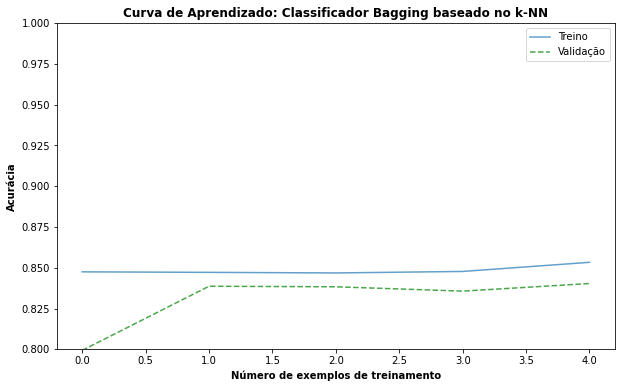

In [41]:
# Gráfico da curva de aprendizado
plt.figure(figsize = (10,6))
plt.plot(acc_train_knn_bagging, alpha=0.7)         # Treino
plt.plot(acc_val_knn_bagging, 'g--', alpha=0.7)     # Validação

# Rótulos e legendas dos gráficos
plt.xlabel('Número de exemplos de treinamento', fontweight='bold')
plt.ylabel('Acurácia', fontweight='bold')
plt.title('Curva de Aprendizado: Classificador Bagging baseado no k-NN', fontweight='bold')
plt.legend(['Treino', 'Validação'])
plt.ylim(0.8, 1.0)

Pelo gráfico acima, é possível observar um comportamento distinto em relação aos demais anteriormente analisados, visto que a curva de aprendizado para dados de treinamento apresenta uma trajetória praticamente constante à medida que o número de exemplos de treinamento aumenta. Além disso, a curva de aprendizado para dados de validação apresenta uma leve tendência ascendente a partir de 1 exemplo de treinamento (esta tendência permanece até 2 exemplos de treinamento, onde mantém um comportamento praticamente constante). Em ambos os casos, a acurácia permanece entre 0.825 e 0.85.

**Classificador Bagging baseado no Random Forest**

In [42]:
# Aplicação da função para comparação dos resultados de validação e treino
_, acc_treino, acc_val = learning_curve(randomforest_bagging,
                                        X_train_norm,
                                        y_train,
                                        scoring = 'accuracy',
                                        random_state = 31,
                                        cv = cv)

In [43]:
# Cálculo dos scores baseado na média das rodadas
acc_train_randomforest_bagging = np.mean(acc_treino, axis=1)
acc_val_randomforest_bagging = np.mean(acc_val, axis=1)

(0.8, 1.0)

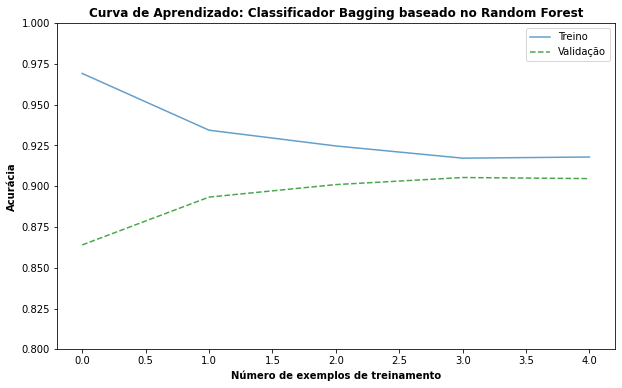

In [44]:
# Gráfico da curva de aprendizado
plt.figure(figsize = (10,6))
plt.plot(acc_train_randomforest_bagging, alpha=0.7)         # Treino
plt.plot(acc_val_randomforest_bagging, 'g--', alpha=0.7)     # Validação

# Rótulos e legendas dos gráficos
plt.xlabel('Número de exemplos de treinamento', fontweight='bold')
plt.ylabel('Acurácia', fontweight='bold')
plt.title('Curva de Aprendizado: Classificador Bagging baseado no Random Forest', fontweight='bold')
plt.legend(['Treino', 'Validação'])
plt.ylim(0.8, 1.0)

Pelo gráfico acima, é possível observar que a partir de 1 exemplo de treinamento o algoritmo está começando a se ajustar aos exemplos do conjunto de treinamento e de validação. Diante disso, é possível observar que a acurácia do modelo com os dados de treinamento apresenta um tendência descendente e a acurácia do modelo com os dados de validação apresenta uma tendência ascendente. Em outras palavras, o gráfico acima mostra que à medida que o número de exemplos de treinamento aumenta maior tende a ser o erro de treinamento e menor tende a ser o erro de validação. Diante disso, é possível observar um possível problema de underfitting.

**Comparativo entre as curvas de aprendizado**

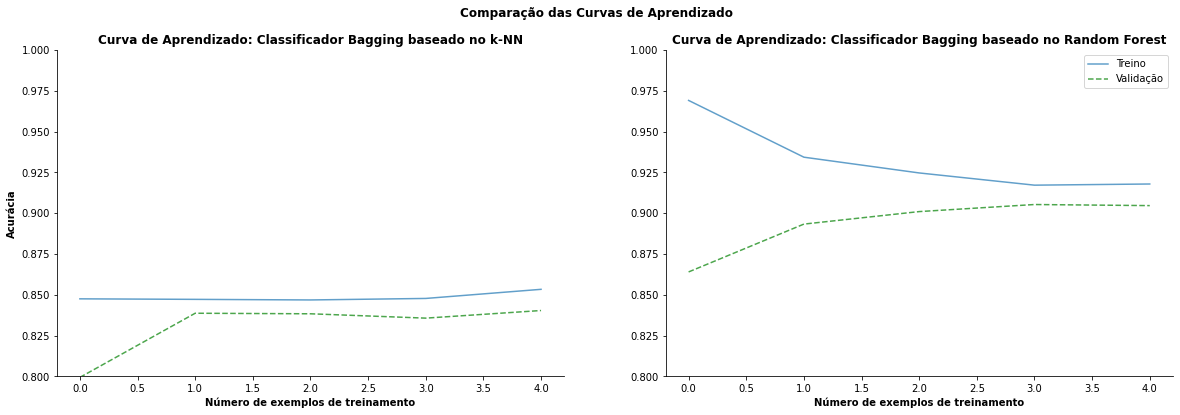

In [45]:
fig = plt.figure(figsize=(20,6))
fig.suptitle('Comparação das Curvas de Aprendizado', fontweight='bold')

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Curva de aprendizado - Classificador Bagging baseado no k-NN
ax1.plot(acc_train_knn_bagging, alpha=0.7)         # Treino
ax1.plot(acc_val_knn_bagging, 'g--', alpha=0.7)     # Validação

# Rótulos e legendas dos gráficos
ax1.set_xlabel('Número de exemplos de treinamento', fontweight='bold')
ax1.set_ylabel('Acurácia', fontweight='bold')
ax1.set_title('Curva de Aprendizado: Classificador Bagging baseado no k-NN', 
              fontweight='bold')
ax1.set_ylim(0.8, 1.0)

# Curva de aprendizado - Classificador Bagging baseado no Random Forest
ax2.plot(acc_train_randomforest_bagging, alpha=0.7)         # Treino
ax2.plot(acc_val_randomforest_bagging, 'g--', alpha=0.7)     # Validação

# Rótulos e legendas dos gráficos
ax2.legend(['Treino', 'Validação'], loc='upper right')
ax2.set_xlabel('Número de exemplos de treinamento', fontweight='bold')
ax2.set_title('Curva de Aprendizado: Classificador Bagging baseado no Random Forest', 
              fontweight='bold')
ax2.set_ylim(0.8, 1.0)

# Ajustes visuais finais
sns.despine()

Comparando os dois gráficos é possível observar uma nítida diferença entre as curvas de aprendizado dos classificadores baseados no k-NN e no Random Forest.

* As curvas de aprendizado para o classificador baseado no Random Forest apresentam uma redução da acurácia para os dados de treino e um aumento da acurácia para dados de validação.

* A partir de 1 exemplo de treinamento, a curva de treino para classificador baseado no k-NN apresenta comportamento constante à medida que o número de exemplos de treinamento aumenta. Jà a curva de validação apresenta uma leve queda entre 1 e 2 exemplos de treinamento e depois adquire uma trajetória praticamente constante.

* O patamar de acurácia das curvas de aprendizado para o classificador baseado no Random Forest permaneceu, em média, superior ao das curvas de aprendizado para o classificador baseado no k-NN.

### (c) Predição e Avaliação dos Modelos

**Classificador Bagging baseado em k-NN**

In [46]:
# Uso dos modelos para predição
y_pred_knn_bagging = knn_bagging.predict(X_test_norm)

In [47]:
# Avaliação do modelo
print(classification_report(y_test, y_pred_knn_bagging))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       306
           1       0.93      0.77      0.85       271

    accuracy                           0.87       577
   macro avg       0.88      0.86      0.86       577
weighted avg       0.87      0.87      0.87       577



**Classificador Bagging Random Forest**

In [48]:
# Uso dos modelos para predição
y_pred_randomforest_bagging = randomforest_bagging.predict(X_test_norm)

In [49]:
# Avaliação do modelo
print(classification_report(y_test, y_pred_randomforest_bagging))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       306
           1       0.97      0.82      0.89       271

    accuracy                           0.90       577
   macro avg       0.91      0.90      0.90       577
weighted avg       0.91      0.90      0.90       577



# 2. Sistemas de Recomendação

**Objetivo**:

* Implementar o algoritmo de aprendizagem de filtragem colaborativa e aplica-lo-á a um conjunto de dados de avaliação.

**Dados da questão**:

* O conjunto de dados de avaliações de filmes consiste em classificações em uma escala de 1 a 5.

* O conjunto de dados tem $n_u = 943$ usuários e $n_m = 1682$ filmes.

* O arquivo que contém o conjunto de dados tem o nome `ex8 movies.mat` e contém as matrizes denominadas $\mathrm{Y}$ e $\mathrm{R}$.

* A matriz $\mathrm{Y}$ (de ordem *número de filmes $\times$ número de usuários*) armazena as classificações $y^{(i,j)}$ (de 1 a 5).

* A matriz $\mathrm{R}$ é uma matriz de indicadores de valor binário, onde $\mathrm{R}(i,j) = 1$, se o usuário $j$ forneceu classificação para o filme $i$ e $\mathrm{R}(i,j) = 0$ em caso contrário.

* Objetivo da filtragem colaborativa: prever as classificações de filmes para os filmes que os usuários ainda não classificaram, ou seja, entradas com $\mathrm{R}(i,j) = 0$.

* O arquivo `ex8 movieParams.mat` contém as matrizes $\mathrm{X}$ e $\mathrm{\Theta}$.

* A $i$-ésima linha de $\mathrm{X}$ corresponde ao vetor de características $x^{(i)}$ para o $i$-ésimo filme.

* A $j$-ésima linha de $\mathrm{\Theta}$ corresponde a um vetor de parâmetros $\theta^{(j)}$, para o $j$-ésimo usuário.

* Tanto $x^{(i)}$ quanto $\theta^{(j)}$ são vetores n-dimensionais.

Obs.: para o exercício, utilizar $n=100$ ($x^{(i)} \in \mathbb{R}^{100}$ e $\theta^{(j)} \in \mathbb{R}^{100}$). Neste sentido, $\mathrm{X}$ é uma matriz $n_m \times 100$ e $\mathrm{\Theta}$ é uma matriz $n_u \times 100$.

## 2.1. Algoritmo de aprendizagem de filtragem colaborativa

**Objetivo**:

* Implementar o algoritmo de filtragem colaborativa.

* Implementar a função de custo (sem regularização).

* Calcular a função de custo e o gradiente para a filtragem colaborativa, onde os parâmetros para a função são $\mathrm{X}$ e $\mathrm{\Theta}$.

**Dados da questão**:

* O algoritmo de filtragem colaborativa no contexto das recomendações de filmes considera um conjunto de vetores de parâmetros $n$-dimensionais $x^{(i)}, \dots, x^{(n_m)}$ e $\theta^{(1)}, \dots, \theta^{(n_u)}$, onde o modelo prediz a avaliação para o filme $i$ pelo usuário $j$ como $y^{(i,j)} = \left (\theta^{(j)}\right )^T x^{(i)}$.

* Dado um conjunto de dados que consiste em um conjunto de avaliações produzidas por alguns usuários para alguns filmes, o algoritmo deve aprender os vetores de parâmetros $x^{(i)}, \dots, x^{(n_m)}$ e $\theta^{(1)}, \dots, \theta^{(n_u)}$ que produzem o melhor ajuste (minimizam o erro quadrático).

**Aspectos conceituais**:

Sistemas de recomendação são técnicas e métodos que fornecem sugestões para itens que são mais prováveis de serem do interesse de um usuário particular. A sugestão relaciona diversos processos de tomada de decisão (como quais itens comprar, qual música ouvir, qual filme assistir, qual notícia online ler).

O termo "item" é o termo geral utiliado para denotar o objeto que o sistema recomendará para o usuário. Um sistema de recomendação normalmente foca em um tipo específico de item e é customizado para fornecer sugestões úteis e efetivas para este tipo específico de itens (de acordo com design, interface gráfica de usuário e técnica de recomendação básica usada para gerar as recomendações do sistema).

Conforme mencionado anteriormente, o propósito do sistema de recomendação é sugerir itens relevantes aos usuários. Para realizar estar tarefa, há duas principais categorias de métodos utilizadas pelo sistema de recomendação: métodos de filtragem colaborativa e métodos baseados em conteúdo.

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1590777872/rec1_v60sj3.png" width="50%"/> {<small>**Fonte: [Datacamp](https://www.datacamp.com/community/tutorials/recommender-systems-python)**</small>}

<img src="https://miro.medium.com/max/687/1*-Jr1l2rlj9SBcCzlDHtN5g.jpeg" width="50%"/> {<small>**Fonte: [Heartbeat](https://heartbeat.fritz.ai/recommender-systems-with-python-part-ii-collaborative-filtering-k-nearest-neighbors-algorithm-c8dcd5fd89b2)**</small>}

**(a) Métodos de filtragem colaborativa**:

A ideia por trás dos métodos de filtragem colaborativa é a resolução do problema de recomendação por meio da investigação das associações entre usuários e itens. Estes métodos são baseados somente nas interações passadas registradas entre usuários e itens a fim de produzir novas recomendações. Estas interações são armazenadas em uma matriz (matriz de interações usuário-item). A ideia principal é que estas interações passadas item-usuários são suficientes para detectar usuários similares e/ou itens similares e, portanto, realizar predições com base nestes proximidades estimadas.

Em resumo, os métodos de filtragem colaborativa analisam a relação entre usuários e interdependências entre items a fim de identificar novas associações usuário-item (que ocorre por meio do aprendizado automátio de características)

Os algoritmos de filtragem colaborativa podem ser divididos em 2 sub-categorias:

* Abordagens baseadas em memória: trabalham diretamente com valores das interações gravadas, sem a presença de modelos e, essencialmente, baseadas na busca dos vizinhos mais próximos.

* Abordagens baseada em modelo: assume um modelo "gerador" subjacente que explica as interações usuário-item e tenta descobri-lo a fim de fazer novas predições.

**(b) Métodos baseados em conteúdo**: 

Os métodos baseados em conteúdo são métodos que utilizam informação adicional sobre usuários e/ou items. A ideia por trás destes métodos é a tentativa de construção de um modelo, baseado nas "características" disponíveis, que explicam as interações usuário-item observadas. Os sistemas de recomendação baseados nestes métodos personalizam a informação que chega ao usuário com base em seus interesses, informações relvantes, etc.



### 2.1.1. Análise inicial dos dados

**Importação e leitura dos dados**

In [50]:
# Leitura dos dados
data = loadmat(os.path.join('dados', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

In [51]:
# Inspeção da dimensão da matirz de classificações
Y.shape

(1682, 943)

A matriz de classificações $\mathrm{Y}$ possui dimensão 1682 $\times$ 943. Em outras palavras, esta matriz possui ratings de 943 usuários sobre 1682 filmes.

In [52]:
# Dimensão da matriz de indicadores
R.shape

(1682, 943)

A matriz de indicadores $\mathrm{R}$ possui dimensão 1682 $\times$ 943. Em outras palavras, esta matriz possui ratings de 943 usuários sobre 1682 filmes. A matriz $\mathrm{R}$ é uma matriz de indicadores de valor binário, onde $\mathrm{R}(i,j) = 1$, se o usuário $j$ forneceu classificação para o filme $i$ e $\mathrm{R}(i,j) = 0$ em caso contrário.

In [53]:
#  A partir da matriz, é possível computar estatísticas como a avaliação média.
print('Avaliação média para filme 1 (Toy Story): %f / 5' % np.mean(Y[0, R[0, :]]))

Avaliação média para filme 1 (Toy Story): 4.520679 / 5


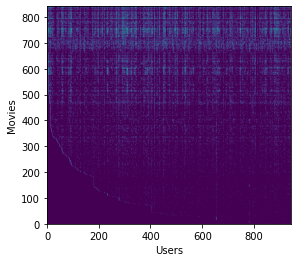

In [54]:
#  É também possível ter uma perspectiva gráfica das avaliações com o comando imagesc
plt.figure()
plt.imshow(Y, aspect='equal', origin='upper', extent=(0, Y.shape[1], 0, Y.shape[0]/2.0))
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show()

# A função imshow() é utilizada para mostrar os dados como uma imagem

### 2.1.2. Função de custo de filtragem colaborativa

**Dado da questão**:

* Expressão para a função de custo para a filtragem colaborativa (sem regularização):

$$
J \left ( x^{(i)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)} \right ) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left ( \left ( \theta^{(j)} \right )^T x^{(i)} - y^{(i,j)} \right )^2
$$

**Objetivo**:

* Implementar a função de custo para a filtragem colaborativa para calcular o custo em uma variável de nome $J$. É preciso acumular o custo para o usuário $j$ e o filme $i$ somente se $R(i,j) = 1$.

* Testar a função de custo para a filtragem colaborativa (resultado esperado: $22,22$).

**Aplicação**:

A função `cofiCostFunc` calcula a função de custo e o gradiente para a filtragem colaborativa. Os parâmetros da função (os valores que o modelo tentará aprender) são `X`e `Theta`. Para utilizar um minimizador pronto, tal como a função `minimize` do scipy, a função de custo foi configurado para desenvolver os parâmetros em um único vetor chamado `params`.

Apesar da questão pedir a implementação da função de custo sem regularização o código abaixo já foi elaborado considerando a regularização (representado por `lambda_`).

In [55]:
# Definição da função para o cálculo do custo da filtragem colaborativa
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):

    # Obtém as matrizes X e Theta a partir dos params
    X = params[:num_movies * num_features].reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:].reshape((num_users, num_features))

    # Função de custo
    diff = np.matmul(X, Theta.transpose()) - Y
    J = 1 / 2 * (diff ** 2 * R).sum()

    # Gradiente Descendente
    X_grad = np.matmul(diff * R, Theta)
    Theta_grad = np.matmul((diff * R).transpose(), X)

    # Cálculo com regularização
    J += lambda_ / 2 * ((Theta ** 2).sum() + (X ** 2).sum())

    X_grad += lambda_ * X
    Theta_grad += lambda_ * Theta

    grad = np.concatenate([X_grad.reshape(-1), Theta_grad.reshape(-1)])
    return J, grad

In [56]:
# Carregamento os parametros previamente treinados (X, Theta, num_users, num_movies, num_features)
data = loadmat(os.path.join('dados', 'ex8_movieParams.mat'))
X = data['X']
Theta = data['Theta']
num_users = np.asscalar(data['num_users'])
num_movies = np.asscalar(data['num_movies'])
num_features = np.asscalar(data['num_features'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys


In [57]:
# Inspeção da dimensão das matrizes de feature (X) e de parâmetros (Theta)
print(X.shape, Theta.shape)

(1682, 10) (943, 10)


In [58]:
# Inspeção do nº de usuários
print("nº total de usuários: {}".format(num_users))

nº total de usuários: 943


In [59]:
# Inspeção do nº de filmes
print("nº total de filmes: {}".format(num_movies))

nº total de filmes: 1682


In [60]:
# Inspeção do nº de features
print("nº total de features: {}".format(num_features))

nº total de features: 10


In [61]:
#  Redução do tamanho do conjunto de dados para a execução ser mais rápida
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [62]:
#  Cálculo da função de custo para a filtragem colaborativa
J = cofiCostFunc(np.concatenate([X.reshape(-1), Theta.reshape(-1)]), Y, R,
                 num_users, num_movies, num_features, 0)[0]
           
print('Custo computado usando parâmetros pré-treinados: %f \n(valor deve ser próximo de 22.22)' % J)

Custo computado usando parâmetros pré-treinados: 22.224604 
(valor deve ser próximo de 22.22)


### 2.1.3. Gradiente de filtragem colaborativa

**Objetivo**:

* Implementar o gradiente (sem regularização) da função de custo.

**Dados da questão**:

* Os gradientes da função de custo são dados por:

$$
\frac{\partial J}{\partial x^{(i)}_k} = \sum_{j:r(i,j)=1}\left ( \left ( \theta^{(j)} \right )^T x^{(i)} - j^{(i,j)} \right ) \theta^{(j)}_k
$$

$$
\frac{\partial J}{\partial \theta^{(j)}_k} = \sum_{i:r(i,j)=1}\left ( \left ( \theta^{(j)} \right )^T x^{(i)} - j^{(i,j)} \right ) x^{(j)}_k
$$

* A função deve retornar o gradiente para ambos os conjuntos de variáveis, armazenando-os em um único vetor.

**Aplicação**:

In [63]:
#  Cálculo do gradiente associado à função de custo
grad = cofiCostFunc(np.concatenate([X.reshape(-1), Theta.reshape(-1)]), Y, R,
                 num_users, num_movies, num_features, 0)[1]
grad

array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
         3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
        -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
        -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
         4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
        -3.47410789,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])

Inicialmente, a função de custo e o gradiente descendente foram calculados para a filtragem colaborativa. Posteriormente, a função `checkCostFunction` é implementada para verificar se o gradiente está correto.

A função `checkCostFunction` cria um problema de filtragem colaborativa para verificar a função de custo e o gradiente. Como resultado da execução da função, serão gerados o gradiente analítico (produzido pelo código) e os gradiente numérico (calculado por meio de `computeNumericalGradient`. Espera-se que ambos os valores sejam semelhantes.



In [64]:
def checkCostFunction(cofiCostFunc, lambda_=0.):
    # Criação do problema
    X_t = np.random.random((4, 3))
    Theta_t = np.random.random((5, 3))

    # Eliminação da maioria das entradas
    Y = np.matmul(X_t, Theta_t.transpose())
    Y[np.random.random(Y.shape) > 0.5] = 0
    R = np.zeros_like(Y)
    R[Y != 0] = 1

    # Execução da verificação do gradiente
    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]

    numgrad = computeNumericalGradient(
        lambda t: cofiCostFunc(t, Y, R, num_users, num_movies, num_features, lambda_),
        np.concatenate([X.reshape(-1), Theta.reshape(-1)]))

    cost, grad = cofiCostFunc(np.concatenate([X.reshape(-1), Theta.reshape(-1)]),
        Y, R, num_users, num_movies, num_features, lambda_)

    print(np.column_stack([numgrad, grad]))
    print('\nAs 2 colunas acima devem ser similares.'
          '\n(coluna esquerda: Gradiente Numérico, coluna direita: Gradiente Analítico)')

    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print('\nSe a implementação da função de custo estiver correta, então a diferença '
          '\nrelativa será pequena (menor que 1e-9).')
    print('\nDiferença Relativa: %g' % diff)

A função `computeNumericalGradient` calcula o gradiente utilizando "diferenças infinitas" e fornece uma estimativa numérica do gradiente.

In [65]:
def computeNumericalGradient(J, theta):
    """
    J : função de custo que será utilizada para estimar o gradiente numérico.
    theta : parâmetros utilizado para calcular o gradiente numérico.
    """
    numgrad = np.zeros_like(theta).reshape(-1)
    perturb = np.zeros_like(theta).reshape(-1)
    e = 1e-4
    
    for p in range(theta.size):
        # Set perturbation vector
        perturb[p] = e
        loss1, _ = J(theta - perturb.reshape(theta.shape))
        loss2, _ = J(theta + perturb.reshape(theta.shape))
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0

    return numgrad.reshape(theta.shape)

In [66]:
# Verificação do Gradiente
checkCostFunction(cofiCostFunc)

[[ 1.26476152e+01  1.26476152e+01]
 [ 1.48926149e+00  1.48926149e+00]
 [-2.53564834e+00 -2.53564834e+00]
 [-2.75226970e+00 -2.75226970e+00]
 [ 8.16836054e-01  8.16836054e-01]
 [ 8.71394069e-01  8.71394069e-01]
 [ 1.16895063e-02  1.16895063e-02]
 [-4.16216229e-03 -4.16216230e-03]
 [-4.02445650e-03 -4.02445650e-03]
 [-3.07914630e+00 -3.07914630e+00]
 [ 5.49551388e+00  5.49551388e+00]
 [-7.07073272e-01 -7.07073272e-01]
 [ 1.03268756e+01  1.03268756e+01]
 [-3.50881434e+00 -3.50881434e+00]
 [ 3.46935532e+00  3.46935532e+00]
 [-3.83647498e+00 -3.83647498e+00]
 [-1.66013758e+00 -1.66013758e+00]
 [-2.97007305e-01 -2.97007305e-01]
 [ 1.40127409e+00  1.40127409e+00]
 [-3.10303810e+00 -3.10303810e+00]
 [ 9.87917558e-01  9.87917558e-01]
 [-1.84098334e+00 -1.84098334e+00]
 [-2.71133548e+00 -2.71133548e+00]
 [ 3.11418515e-01  3.11418515e-01]
 [-1.52465402e+01 -1.52465402e+01]
 [-1.45740310e+00 -1.45740310e+00]
 [-2.49317976e+00 -2.49317976e+00]]

As 2 colunas acima devem ser similares.
(coluna esque

### 2.1.4. Parênteses (conteúdo extra)

**Função de custo com regularização para filtragem colaborativa**

Expressão da função de custo com filtragem colaborativa com regularização:

$$
J \left ( x^{(i)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)} \right ) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left ( \left ( \theta^{(j)} \right )^T x^{(i)} - y^{(i,j)} \right )^2 + \\ + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n \left (\theta^{(j)} \right )^2 + \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left (x^{(i)} \right )^2
$$

Para o cálculo do custo com regularização será utilizada a função `cofiCostFunc` definida anteriormente com um $\lambda$ diferente de zero.

In [67]:
#  Cálculo do custo
J = cofiCostFunc(np.concatenate([X.reshape(-1), Theta.reshape(-1)]),
                 Y, R, num_users, num_movies, num_features, 1.5)[0]
           
print('Valor do custo calculado (lambda = 1.5): %.2f' % J)

Valor do custo calculado (lambda = 1.5): 31.34


Comparando os valores das funções de custo para filtragem colaborativa, é possível observar a penalização causada pela inserção do termo de regularização (em virtude da adição dos termos de regularização à função de custo).

**Gradiente com regularização para filtragem colaborativa**

Expressão do gradiente descendente com regularização:

$$
\frac{\partial J}{\partial x^{(i)}_k} = \sum_{j:r(i,j)=1}\left ( \left ( \theta^{(j)} \right )^T x^{(i)} - j^{(i,j)} \right ) \theta^{(j)}_k + \lambda x^{(j)}_k
$$

$$
\frac{\partial J}{\partial \theta^{(j)}_k} = \sum_{i:r(i,j)=1}\left ( \left ( \theta^{(j)} \right )^T x^{(i)} - j^{(i,j)} \right ) x^{(j)}_k + \lambda \theta^{(j)}_k
$$

Isso implica na adição de $\lambda x^{(j)}_k$ à `X_grad[i,:]` e na adição de $\lambda \theta^{(j)}_k$ à `Theta_grad[j,:]` no código `cofiCostFunc` (essas inserções já foram realizadas anteriormente).

In [68]:
# Gradiente Descendente
grad = cofiCostFunc(np.concatenate([X.reshape(-1), Theta.reshape(-1)]),
                    Y, R, num_users, num_movies, num_features, 1.5)[1]
grad

array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
         2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
        -0.89247334,   0.29684395,   1.06300933,   0.66738144,
         0.60252677,   4.90185327,  -0.19747928, -10.13985478,
         2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
        -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
         1.09289758,  -0.40784086,   0.49026541])

## 2.2 Aprendizado de Recomendações para Filmes

**Dados da questão**:

* Após a implementação do gradiente e da função de custo de filtragem colaborativa, é possível treinar o algoritmo para fazer recomendações de filmes.

* Para testar o treinamento, o usuário pode definir suas próprias preferências de filmes, a fim de obter suas próprias recomendações de filmes quando o algoritmo for executado.

* O arquivo `movie_ids.txt` contém a lista de todos os filmes e seus números no conjunto de dados.

**Objetivo**:

* Implementar um script para calcular as classificações principais para um dado usuário e exibir os filmes recomendados.

### 2.2.1 Definição de avaliações para um novo usuário

Antes de realizar o treinamento do modelo de filtragem colaborativa, serão adicionadas avaliações para um novo usuário (realização de algumas avaliações correspondentes a um novo usuário).

In [69]:
# Leitura dos dados
def loadMovieList():
    """
    reads the fixed movie list in movie.txt
    and returns a cell array of the words in movieList.
    """

    ## Read the fixed movieulary list
    with open('dados/movie_ids.txt', encoding='ISO-8859-1') as fid:
        # Store all movies in cell array movie{}
        n = 1682  # Total number of movies

        movieList = []
        for i in range(n):
            # Read line
            line = fid.readline()
            # Word Index (can ignore since it will be = i)
            idx, movieName = line.split(' ', maxsplit=1)
            # Actual Word
            movieList.append(movieName.strip())

    return movieList

In [70]:
# Carga dos dados dos filmes
movieList = loadMovieList()

In [71]:
# Inspeção das 10 primeiras linhas
movieList[:10]

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)']

In [72]:
#  Inicialização do vetor de avaliacoes do novo usuario
my_ratings = np.zeros(1682)

In [73]:
# Atribuição dos ratings a alguns filmes (definição da avaliação de alguns filmes na lista)
my_ratings[0] = 4     # Toy Story (1995)
my_ratings[97] = 2    # Silence of the Lambs (1991)
my_ratings[6] = 3     # Twelve Monkeys (1995)
my_ratings[11] = 5    # The Usual Suspects (1995)
my_ratings[53] = 4    # Outbreak (1995)
my_ratings[63] = 5    # The Shawshank Redemption (1994)
my_ratings[65] = 3    # While You Were Sleeping (1995)
my_ratings[68] = 5    # Forrest Gump (1994)
my_ratings[182] = 4   # Alien (1979)
my_ratings[225] = 5   # Die Hard 2 (1990)
my_ratings[354] = 5   # Sphere (1998)

print('Avaliacoes do novo usuario:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('\tAvaliou %d para %s' % (my_ratings[i], movieList[i]))

Avaliacoes do novo usuario:
	Avaliou 4 para Toy Story (1995)
	Avaliou 3 para Twelve Monkeys (1995)
	Avaliou 5 para Usual Suspects, The (1995)
	Avaliou 4 para Outbreak (1995)
	Avaliou 5 para Shawshank Redemption, The (1994)
	Avaliou 3 para While You Were Sleeping (1995)
	Avaliou 5 para Forrest Gump (1994)
	Avaliou 2 para Silence of the Lambs, The (1991)
	Avaliou 4 para Alien (1979)
	Avaliou 5 para Die Hard 2 (1990)
	Avaliou 5 para Sphere (1998)


### 2.2.2. Aprendizado de Recomendacoes para Filmes

In [74]:
# Leitura dos dados
data = loadmat(os.path.join('dados', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

In [75]:
# Inspeção da dimensão da matriz de avaliações
Y.shape

(1682, 943)

A matriz de classificações $\mathrm{Y}$ possui dimensão 1682 $\times$ 943. Em outras palavras, esta matriz possui ratings de 943 usuários sobre 1682 filmes.

In [76]:
# Dimensão da matriz de indicadores
R.shape

(1682, 943)

A matriz de indicadores $\mathrm{R}$ possui dimensão 1682 $\times$ 943. Em outras palavras, esta matriz possui ratings de 943 usuários sobre 1682 filmes. A matriz $\mathrm{R}$ é uma matriz de indicadores de valor binário, onde $\mathrm{R}(i,j) = 1$, se o usuário $j$ forneceu classificação para o filme $i$ e $\mathrm{R}(i,j) = 0$ em caso contrário.

As avaliações definidas para o novo usuário anteriormente serão adicionadas ao dataset. A partir daí, o script irá treinar o modelo de filtragem colaborativa.

In [77]:
#  Inserção das avaliações realizadas anteriormente nas matrizes de dados
Y = np.column_stack([my_ratings, Y])
R = np.column_stack([(my_ratings != 0).astype(int), R])

In [78]:
# Função para normalização das avaliações
def normalizeRatings(Y, R):
    """
    normaliza Y de tal forma que os filmes possuam uma avaliacao de 0 em media,
    e retorna a avaliação média em Ymean.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros_like(Y)
    for i in range(m):
        idx = R[i] == 1
        Ymean[i] = Y[i, idx].mean()
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ynorm, Ymean

In [79]:
#  Normalização das avaliações
Ynorm, Ymean = normalizeRatings(Y, R)

In [80]:
#  Valores úteis
num_users = Y.shape[1]        # Definição do nº de usuários
num_movies = Y.shape[0]       # Definição do nº de filmes
num_features = 10             # Definição do número de características

In [81]:
# Definição dos parâmetros iniciais (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.reshape(-1), Theta.reshape(-1)])

In [82]:
# Definição dos parâmetros para a minimização da função de custo 
lambda_ = 10   # fator de regularizacao
options = {'disp': True, 'maxiter': 1000.0}

# Configuração das funções de custo e do gradiente
cost = lambda t: cofiCostFunc(t, Ynorm, R, num_users, num_movies, num_features, lambda_)[0]
grad = lambda t: cofiCostFunc(t, Ynorm, R, num_users, num_movies, num_features, lambda_)[1]

In [83]:
# Minimização da função de custo
res = opt.minimize(cost, initial_parameters, method='CG', jac=grad, options=options)

Optimization terminated successfully.
         Current function value: 38951.847560
         Iterations: 420
         Function evaluations: 649
         Gradient evaluations: 649


In [84]:
theta = res.x
cost = res.fun

# Extrai as matrizes X e Theta a partir de theta
X = theta[:num_movies * num_features].reshape((num_movies, num_features))
Theta = theta[num_movies * num_features:].reshape((num_users, num_features))

print('Aprendizado do Sistema de Recomendação finalizado.')

Aprendizado do Sistema de Recomendação finalizado.


### 2.2.3. Realização de recomendações

Após treinamento do modelo, é possível realizar recomendações por meio do cálculo da matriz de predições. Para predizer a classificação do filme $i$ para o usuário $j$ é preciso calcular $\left(\theta^{(j)} \right)^T x^{(i)}$. 

In [85]:
# Cálculo da matriz de predições
p = np.matmul(X, Theta.transpose())
my_predictions = p[:, 0] + Ymean

movieList = loadMovieList()

# Retorna os índices que ordenariam uma matriz.
ix = my_predictions.argsort()[::-1]

In [86]:
# ordena predicoes em ordem decrescente
pre=np.array([[idx, p] for idx, p in enumerate(my_predictions)])
post = pre[pre[:,1].argsort()[::-1]]
r = post[:,1]
ix = post[:,0]

# Visualização das principais recomendações ordenadas pela classificação dos filmes
print('\nRecomendacoes principais:')
for i in range(10):
    j = int(ix[i])
    print('\tPrevisão de avaliacao %.1f para %s' % (my_predictions[j], movieList[j]))

print('\nAvaliacoes originais fornecidas:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('\tAvaliou %d para %s' % (my_ratings[i], movieList[i]))


Recomendacoes principais:
	Previsão de avaliacao 5.0 para Star Kid (1997)
	Previsão de avaliacao 5.0 para Prefontaine (1997)
	Previsão de avaliacao 5.0 para They Made Me a Criminal (1939)
	Previsão de avaliacao 5.0 para Great Day in Harlem, A (1994)
	Previsão de avaliacao 5.0 para Someone Else's America (1995)
	Previsão de avaliacao 5.0 para Santa with Muscles (1996)
	Previsão de avaliacao 5.0 para Entertaining Angels: The Dorothy Day Story (1996)
	Previsão de avaliacao 5.0 para Aiqing wansui (1994)
	Previsão de avaliacao 5.0 para Saint of Fort Washington, The (1993)
	Previsão de avaliacao 5.0 para Marlene Dietrich: Shadow and Light (1996)

Avaliacoes originais fornecidas:
	Avaliou 4 para Toy Story (1995)
	Avaliou 3 para Twelve Monkeys (1995)
	Avaliou 5 para Usual Suspects, The (1995)
	Avaliou 4 para Outbreak (1995)
	Avaliou 5 para Shawshank Redemption, The (1994)
	Avaliou 3 para While You Were Sleeping (1995)
	Avaliou 5 para Forrest Gump (1994)
	Avaliou 2 para Silence of the Lambs, T

# 3. Redes Neurais Artificiais (ANN)

**Aspectos conceituais**

Para Hearty (2016), as redes neurais são uma classe de modelos matemáticos treinados para produzirem e otimizarem uma definição para uma função sobre um conjunto de características de entrada. Segundo Géron (2019), as Redes Neurais Artificiais estão no centro do Deep Learning. Além disso, são versáteis, poderosos, escaláveis, sendo alternativa ideal para lidar com tarefas complexas de Aprendizado de Máquinas.  

Em termos gerais, uma rede neural é composta pelos seguintes elementos:

* Processo de aprendizado: uma rede neural aprende por meio dos parâmetros de ajustamento dentro da função de peso de seus nós.

* Conjunto de neurônios ou pesos: cada neurônio contém uma função de peso (ou função de ativação) que manipula os dados de entrada.

* Funções de conectividade: as funções de conectividade podem controlar quais nós podem retransmitir os dados para outros nós.

**Perceptron**

O *Perceptron* é um das arquiteturas mais simples de ANN, baseada em um neurônio um pouco diferente chamado de *threshold logic unit* (TLU). Os inputs e outputs são números e cada conexão de entrada está associada com um peso. A TLU calcula uma soma ponderada de seus inputs ($z = \mathrm{x}^T \mathrm{w}$) e aplica uma *step function* à essa soma e produz o resultado $h_\mathrm{w}(\mathrm{x}) = \text{step}(z)$, onde $z = \mathrm{x}^T \mathrm{w}$.

<img src="https://github.com/cristianegea/PPCIC/blob/main/Aprendizado%20de%20Máquinas/Trabalho%203/img/img2.png?raw=true" width="50%"/>{<small>**Fonte: Géron 2019**</small>}

Um *Perceptron* é composto por uma única camada de TLUs, com cada TLU conectada a todas as entradas. Quando todos os neurônios em uma camada estão conectados a todos os neurônios da camada anterior (ou seja, seus neurônios de entrada), a camada é chamada de camada totalmente conectada (ou camada densa). 

Segundo Géron (2019), o cálculo das saídas de uma camada de neurônios artificiais para várias instâncias ao mesmo tempo pode ser representado pela seguinte expressão

$$
h_{\mathrm{w,b}}(\mathrm{x}) = \phi (\mathrm{wx} + \mathrm{b})
$$

onde $\mathrm{x}$ é a matriz de características, $\mathrm{w}$ é a matriz de pesos, $\mathrm{b}$ é o vetor de *bias* e $\phi()$ á função de ativação.

A regra de aprendizado de um *Perceptron* reforça as conexões que ajudam a reduzir o erro. Mais especificamente, o *Perceptron* é alimentado com uma instância de treinamento por vez e, para cada instância, ele faz suas previsões. Para cada neurônio de saída que produziu uma previsão errada, ele reforça os pesos de conexão das entradas que teriam contribuído para a previsão correta.

## 3.1. Redes MLP

**Objetivos**:

* Usar o *framework* PyTorch para treinar um modelo de rede neural MLP para a tarefa de classificação binária.

* Criar um modelo de classificação por meio de uma rede neural MLP (*multi-layer perceptron*) com propagação do erro (*error backpropagation*).

* Utilizar os mesmos conjuntos de treinamento, validação e teste apresentados na Seção 1 (`credtrain.txt` e `credtest.txt`).

* Definir os hiperparâmetros da rede neural (pode-se utilizar uma rede MLP de uma única camada oculta e utilizar o `Grid Search` para sintonização dos demais hiperparâmetros).

* Apresentar os detalhes acerca dos hiperparâmetros selecionados (taxa de aprendizado), quantidade de neurônios, otimizador, funções de ativação, etc.).

* Avaliar a qualidade preditiva do modelo de rede neural gerado sobre os dados contidos no arquivo `credtest.txt`.

* Produzir uma matriz de confusão (*confusion matrix*) relativa aos resultados da fase de testes.

* Apresentar o resultado produzido pela função `classification_report` do Scikit-Learn.

**Aspectos conceituais**

Uma *Multilayer Perceptron* (MLP) é composta por 1 camada de entrada, uma ou mais camadas de TLUs (chamadas de camadas ocultas) e uma camada final de TLU (chamada de camada de saída). As camadas próximas à camada de entrada são usualmente chamadas de camadas inferiores (*lower layers*) e as camadas próximas à camada de saída são chamadas de camadas superiores (*upper layers*). Cada camada, com exceção à camada de saída, inclui um neurônio de *bias* e está totalmente conectada à próxima camada.

A figura abaixo mostra o exemplo da arquitetura de uma MLP com 2 inputs, 1 camada oculta de 4 neurônios 3 neurônios de saída.

<img src="https://github.com/cristianegea/PPCIC/blob/main/Aprendizado%20de%20Máquinas/Trabalho%203/img/img3.png?raw=true" width="50%"/>{<small>**Fonte: Géron 2019**</small>}

#### 3.1.1. Tratamento dos dados

Visto que os datasets utilizados para esta questão são os mesmos da questão 1, o processo de tratamento dos dados será o mesmo. As etapas adicionais realizada nesta seção (em relação à questão 1) são:

* Separação do conjunto de treinamento em subconjuntos de treino e de validação, visto que na questão 1 não foi necessário em virtude do fato de a classe `learning_curve` realizar por conta própria a divisão do dataset em treino e validação para comparação das curvas de aprendizado.

* Transformação dos dados originais em tensores

**Importação e leitura dos dados**

In [87]:
# Definção dos nomes das variáveis (conforme a tabela contida no enunciado)
colnames = ['ESCT', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC',
            'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']

In [88]:
# Leitura dos dados de treino
arquivo = 'dados/credtrain.txt'
data_train = pd.read_csv(arquivo, sep='\t', header=None, names = colnames)

# Leitura dos dados de teste
arquivo = 'dados/credtest.txt'
data_test = pd.read_csv(arquivo, sep='\t', header=None, names = colnames)

**Inspeção dos dados**

In [89]:
# Inspeção da dimensão do dataset
print(data_train.shape, data_test.shape)

(1500, 12) (577, 12)


In [90]:
# Inspeção das primeiras linhas do conjunto de treinamento
data_train.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [91]:
# Inspeção das primeiras linhas do conjunto de treinamento
data_test.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,0,2,500,1,618,10,85,0,36,6,0,0
1,1,0,813,0,552,4,119,0,43,48,119,1
2,3,0,350,0,488,12,66,0,43,0,0,1
3,1,0,1530,0,381,1,398,0,28,48,0,1
4,0,0,688,1,396,10,60,0,49,72,0,1


**Tratamento da variável categórica**

É importante observar que a variável ESCT (Estado Civil) é do tipo categórica, podendo assumir 4 valores diferentes (cada valor corresponde a um estado civil). Assim, diferentemente de NDEP (onde cada valor corresponde a uma quantidade de dependentes), na variável ESCT cada valor corresponde a uma categoria. Contudo, este fato pode trazer inconsistências na criação e treinamento de modelos.

Para mitigar este problema, uma alternativa é tranformar a variável ESCT em uma variável *dummy* (variável binária). Neste sentido, cada categoria da variável ESCT corresponderá a uma variável. Visto que há 4 possíveis categorias para a variável ESCT, obteremos 4 variáveis ESCT binárias.

Uma variável *dummy* é uma variável binária utilizadas para representar categorias. Neste sentido, em um caso de uma variável com 3 ou mais categorias, recomenda-se a criação de $n-1$ dummies. Diante disso, a variável ESCT será transformada em 4 "variantes dummy", onde o valor 1 corresponderá à ocorrência de determinada categoria e o valor 0 corresponderá à não ocorrência.

In [92]:
# Aplicação no conjunto de treinamento
data_train_new = pd.get_dummies(data = data_train, prefix='ESCT', columns=['ESCT'], drop_first=True)

# pd.get_dummies: Convert categorical variable into dummy/indicator variables.

# Inspeção das primeiras linhas
data_train_new.head()

,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE,ESCT_1,ESCT_2,ESCT_3
0,0,360,0,313,9,52,0,25,48,0,1,1,0,0
1,0,350,1,468,10,65,0,33,6,0,1,0,0,0
2,0,1100,0,829,9,125,0,56,48,0,1,0,0,0
3,0,3000,0,552,12,76,1,31,60,0,1,0,0,0
4,0,1000,0,809,12,111,0,24,7,0,1,1,0,0


In [93]:
# Aplicação no conjunto de teste
data_test_new = pd.get_dummies(data = data_test, prefix='ESCT', columns=['ESCT'], drop_first=True)

# pd.get_dummies: Convert categorical variable into dummy/indicator variables.

# Inspeção das primeiras linhas
data_test_new.head()

,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE,ESCT_1,ESCT_2,ESCT_3
0,2,500,1,618,10,85,0,36,6,0,0,0,0,0
1,0,813,0,552,4,119,0,43,48,119,1,1,0,0
2,0,350,0,488,12,66,0,43,0,0,1,0,0,1
3,0,1530,0,381,1,398,0,28,48,0,1,1,0,0
4,0,688,1,396,10,60,0,49,72,0,1,0,0,0


**Separação do conjunto de dados em rótulo ($\mathrm{y}$) e features ($\mathrm{X}$)**

O rótulo ($\mathrm{y}$) corresponde ao vetor contendo a variável alvo (CLASSE), enquanto que features ($\mathrm{x}$) corresponde à matriz de dados.

In [94]:
# Transformação da variável alvo do conjunto de treinamento em vetor
y_train = np.array(data_train_new['CLASSE'])

# Inspeção das primeira linhas
y_train[:5]

array([1, 1, 1, 1, 1])

In [95]:
# Transformação da variável alvo do conjunto de teste em vetor
y_test = np.array(data_test_new['CLASSE'])

# Inspeção das primeira linhas
y_test[:5]

array([0, 1, 1, 1, 1])

In [96]:
# Transformação do conjunto de treinamento remanescente em matriz de dados
features_name_train = list(data_train_new.columns)               # Recuperação dos nomes das colunas
features_name_train.remove('CLASSE')                             # Remoção da variável "CLASSE"
X_train = np.array(data_train_new.loc[:, features_name_train])   # Transformação em matriz

# Inspeção da matriz resultante
X_train

array([[   0,  360,    0, ...,    1,    0,    0],
       [   0,  350,    1, ...,    0,    0,    0],
       [   0, 1100,    0, ...,    0,    0,    0],
       ...,
       [   0,  570,    0, ...,    0,    0,    0],
       [   0,  360,    0, ...,    0,    0,    0],
       [   4,  501,    1, ...,    0,    0,    0]])

In [97]:
# Transformação do conjunto de teste remanescente em matriz de dados
features_name_test = list(data_test_new.columns)               # Recuperação dos nomes das colunas
features_name_test.remove('CLASSE')                            # Remoção da variável "CLASSE"
X_test = np.array(data_test_new.loc[:, features_name_test])   # Transformação em matriz

# Inspeção da matriz resultante
X_test

array([[   2,  500,    1, ...,    0,    0,    0],
       [   0,  813,    0, ...,    1,    0,    0],
       [   0,  350,    0, ...,    0,    0,    1],
       ...,
       [   3, 1200,    0, ...,    0,    0,    0],
       [   0,  600,    0, ...,    1,    0,    0],
       [   0,  800,    1, ...,    0,    0,    0]])

**Separação do conjunto de treinamento em subconjuntos de treino e de validação**

In [98]:
# Separação em subconjunto de treino e subconjunto de validação
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train,
                                                    train_size = 0.8,
                                                    random_state = 31)

In [99]:
# Inspeção das dimensões
print(X_train.shape, y_train.shape, X_train1.shape, y_train1.shape, X_val.shape, y_val.shape,
      X_test.shape, y_test.shape)

(1500, 13) (1500,) (1200, 13) (1200,) (300, 13) (300,) (577, 13) (577,)


**Normalização das features**

De forma semelhante aos trabalhos anteriores, antes de prosseguir será realizada a normalização das características a fim de evitar problemas decorrentes à discrepância nas ordens de grandeza das features.

In [100]:
# Criação do objeto para a padronização das features
scaler_nn = StandardScaler()

# Ajustamento do StandardScaler ao conjunto de dados de treino e padronização dos dados de treino
X_train_norm = scaler_nn.fit_transform(X_train)

# Transformação dos dados de teste com os parâmetros ajustados a partir dos dados de treino
X_test_norm = scaler_nn.transform(X_test)

# Transformação dos dados dos subconjuntos de treino e de validação
X_train1_norm = scaler_nn.transform(X_train1)
X_val_norm = scaler_nn.transform(X_val)

**Transformação dos dados originais em tensores**

Um `torch.Tensor`é uma matriz multi-dimensional contendo elementos de um único tipo de dado. A transformação dos dados originais em tensores ocorre devido ao fato do `PyTorch` não ser capaz de trabalhar com variáveis comuns do Python.

In [101]:
# Conjunto original de treinamento
X_train = Variable(torch.Tensor(X_train_norm).float())
y_train = Variable(torch.Tensor(y_train).long())

# Subconjunto de treino
X_train1 = Variable(torch.Tensor(X_train1_norm).float())
y_train1 = Variable(torch.Tensor(y_train1).long())

# Subconjunto de validação
X_val = Variable(torch.Tensor(X_val_norm).float())
y_val = Variable(torch.Tensor(y_val).long())

# Conjunto de teste
X_test = Variable(torch.Tensor(X_test_norm).float())
y_test = Variable(torch.Tensor(y_test).long())

### 3.1.2. Criação da Rede Neural MLP sem otimização dos hiperparâmetros

**Criação da classe com arquitetura da rede neural MLP**

In [102]:
class Net(nn.Module):
    # Definição da rede neural
    def __init__(self, dimX, nC, neur):
        """
        dimX int: Entradas na primeira camada (quantidade de atributos)
        nC int:  Neurônios de saída (quantidade de classes possíveis)
        neur int: Neurônios na camada oculta  
        """
    
        super(Net, self).__init__()

        # Definição da camada oculta (a rede possui 1 camada oculta)
        self.fc1 = nn.Linear(dimX, neur)
            """
            self.fc1 : recebe neurônios (quantidade de atributos) e fornece a quantidade de neurônios da camada oculta
            nn.Linear : aplica uma transformaçao linear aos dados de entrada => y = x*w^T + b
            """
        
        # Definição da camada de saída
        self.fc2 = nn.Linear(neur, nC)
            """
            self.fc2 : recebe neurônios da camada oculta e fornece a quantidade de neurônios das classes possíveis
            nn.Linear : aplica uma transformaçao linear aos dados da camada oculta => y = x*w^T + b
            """
    
        # Uso da função Sigmoid para classificação binária (tratamento dos dados )
        self.output = nn.Sigmoid()     # Sigmoid activation function

    # Método que corresponde ao passo forward
    def forward(self, X):
        X = F.relu(self.fc1(X))              # Função de ativação para a camada oculta
        X = F.relu(self.fc2(X))              # Função de ativação para a camada de saida
        X = self.output(X)                   # output linear 
        """
        F.relu : F.relu is the Rectified Linear Unit activation function
        """
        
        return X

**Definição dos hiperparâmetros para a criação da rede neural**

Nesta etapa, os hiperparâmetros foram ajustados manualmente. Posteriormente, será realizada a otimização dos hiperparâmetros.

In [103]:
# Parâmetros baseados nos conjuntos de dados
attr_N = X_train1.shape[1]                    # Quantidade de atributos do conjunto de dados
out_Classes = 2                               # Quantidade de classes possíveis do conjunto de dados

Ajuste manual dos parâmetros: Início lr = 0.001, 100 neurônios na camada oculta

Mantido lr e alterado número de neurônios para 200





In [104]:
# Parâmetros definidos arbitrariamente
NUM_NEUR = 200                               # Neurônios na camada oculta
NUM_EPOCHS = 1000                            # Número de épocas
LEARNING_R = 0.001                           # Taxa de aprendizagem

print('Qtde. Atributos de entrada:', attr_N,
      '\nQtde. Classes alvo:', out_Classes,
      '\nNeurônios na camada oculta:', NUM_NEUR,
      '\nNúmero de épocas:', NUM_EPOCHS,
      '\nTaxa de aprendizagem:', LEARNING_R)

Qtde. Atributos de entrada: 13 
Qtde. Classes alvo: 2 
Neurônios na camada oculta: 200 
Número de épocas: 1000 
Taxa de aprendizagem: 0.001


In [105]:
# Criação do objeto com a classe da Rede Neural (definição da rede)
net = Net(attr_N, out_Classes, NUM_NEUR)

# Arquitetura da Rede Neural
print('Arquitetura da Rede Neural:\n', net)

Arquitetura da Rede Neural:
 Net(
  (fc1): Linear(in_features=13, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (output): Sigmoid()
)


**Função de Custo e Otimizador**

Uma vez que o problema é referente a uma tarefa de classificação, é utilizada a *entropia cruzada* como função de custos. Além disso, o otimizador utilizado foi o Gradiente Descendente.

In [106]:
# Parâmetros baseados em algoritmos ou funções
criterion = nn.CrossEntropyLoss()                                  # Entropia cruzada como função de custo
    """
    cross entropy loss is adequate for classification problems
    """
    
optimizer = torch.optim.SGD(net.parameters(), lr = LEARNING_R)     # Configuração do otimizador utilizado
    """
    SGD é utilizado para representar todas as versões do GD
    A versão do GD que será utilizada dependerá do tamanho do lote.
    """

**Treinamento da Rede Neural**

In [107]:
# loop to train the neural net
for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()              # clear gradients => valores do otimizador zerados
    out = net(X_train1)                # net() representa a própria rede neural => predição da rede neural
    loss = criterion(out, y_train1)    # cálculo da função de custo (aplicada à função de entropia cruzada)
    loss.backward()                    # backpropagation, compute gradients
    optimizer.step()                   # apply gradients (atualização dos parâmetros) => otimização dos hiperparâmetros
    
    if epoch % 100 == 0:
        print('At epoch %d the loss is %f' % (epoch, loss.data.item()))

At epoch 0 the loss is 0.688589
At epoch 100 the loss is 0.687373
At epoch 200 the loss is 0.685899
At epoch 300 the loss is 0.684160
At epoch 400 the loss is 0.682261
At epoch 500 the loss is 0.680214
At epoch 600 the loss is 0.678068
At epoch 700 the loss is 0.675859
At epoch 800 the loss is 0.673636
At epoch 900 the loss is 0.671471


**Predição e avaliação da rede neural**

In [108]:
# Predições no conjunto de validação
predict_out = net(X_val)

    """
    Cada predição é composto por um par (predição para cada classe)
    """

# Returns the maximum value of all elements in the input tensor
_, predict_y = torch.max(predict_out, 1)

In [109]:
# Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_val.data, predict_y.data))

# Relatório de avaliação da classificação
print('-' * 60, end='\n\n')
print('Relatório de avaliação da classificação')
print(classification_report(y_val.data, predict_y.data,
                            zero_division=0))

Matriz de confusão
[[129  20]
 [ 43 108]]
------------------------------------------------------------

Relatório de avaliação da classificação
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       149
           1       0.84      0.72      0.77       151

    accuracy                           0.79       300
   macro avg       0.80      0.79      0.79       300
weighted avg       0.80      0.79      0.79       300



**Aplicação da rede neural para predição com dados de teste**

In [110]:
# Predições no conjunto de testes
predict_out = net(X_test)

# Cada predição é composto por um par (predição para cada classe)

# Recupera como valor predito o maior de cada par predito
_, predict_y = torch.max(predict_out, 1)

In [111]:
# Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test.data, predict_y.data))

# Relatório de avaliação da classificação
print('-' * 60, end='\n\n')
print('Relatório de avaliação da classificação')
print(classification_report(y_test.data, predict_y.data,
                            zero_division=0))

Matriz de confusão
[[253  53]
 [ 86 185]]
------------------------------------------------------------

Relatório de avaliação da classificação
              precision    recall  f1-score   support

           0       0.75      0.83      0.78       306
           1       0.78      0.68      0.73       271

    accuracy                           0.76       577
   macro avg       0.76      0.75      0.76       577
weighted avg       0.76      0.76      0.76       577



Comparando os resultados auferidos do conjunto de validação e do conjunto de teste, é possível observar que as métricas de avaliação para os dados de validação é ligeiramente superior às metricas de avaliação para os dados de teste (tanto a acurácia quanto o F1, para ambas as classes, ficaram acima de 0.7).

### 3.1.3. Criação da Rede Neural MLP com otimização dos hiperparâmetros

**Aspectos conceituais**

A desvantagem da configuração manual dos hiperparâmetros é o descohecimento da combinação ótima de hiperparâmetros (dada as diversas combinações possíveis de hiperparâmetros para um determinado modelo). Diante disso, o conhecimento da melhor combinação de hiperparâmetros para um dado dataset torna-se um desafio. Portanto, uma boa opção é a otimização de hiperparâmetros (ou sintonização de hiperparâmetros), que visa buscar objetivamente diferentes valores para os hiperparâmetros do modelo e escolher um conjunto que resulta em um modelo que alcançe o melhor desempenho para um determinado dataset. O resultado da otimização de hiperparâmetros será um único conjunto de hiperparâmetros com bom desempenho que pode ser utilizado para configuração do modelo.

**Definição dos parâmetros iniciais para a criação da arquitetura da rede neural**

In [112]:
# Parâmetros baseados nos conjuntos de dados
attr_N = X_train.shape[1]                   # Quantidade de atributos do conjunto de dados
out_Classes = 2                             # Quantidade de classes possíveis do conjunto de dados

# Parâmetros iniciais para sintonização
NUM_NEUR = 100                              # Neurônios na camada oculta
NUM_EPOCHS = 15                             # Número de épocas
LEARNING_R = 0.001                          # Taxa de aprendizagem

print('Qtde. Atributos de entrada:', attr_N,
      '\nQtde. Classes alvo:', out_Classes,
      '\nNeurônios na camada oculta:', NUM_NEUR,
      '\nNúmero de épocas:', NUM_EPOCHS,
      '\nTaxa de aprendizagem:', LEARNING_R)

Qtde. Atributos de entrada: 13 
Qtde. Classes alvo: 2 
Neurônios na camada oculta: 100 
Número de épocas: 15 
Taxa de aprendizagem: 0.001


**Criação da classe de rede neural**

In [113]:
# Criação da classe da Rede Neural
class Net_(nn.Module):
    # Definição da rede neural
    def __init__(self, dimX, nC, neur):
        """
        dimX int: Entradas na primeira camada (quantidade de atributos)
        nC int:  Neurônios de saída (quantidade de classes possíveis)
        neur int: Neurônios na camada oculta
        """
        
        super(Net_, self).__init__()

        # Definição da camada oculta (a rede possui 1 camada oculta)
        self.fc1 = nn.Linear(dimX, neur)
            """
            self.fc1 : recebe neurônios (quantidade de atributos) e fornece a quantidade de neurônios da camada oculta
            nn.Linear : aplica uma transformaçao linear aos dados de entrada => y = x*w^T + b
            """

        # Definição da camada de saída
        self.fc2 = nn.Linear(neur, nC)
            """
            self.fc2 : recebe neurônios da camada oculta e fornece a quantidade de neurônios das classes possíveis
            nn.Linear : aplica uma transformaçao linear aos dados da camada oculta => y = x*w^T + b
            """

        # Uso da função Sigmoid para classificação binária (tratamento dos dados)
        self.output = nn.Sigmoid()  # Sigmoid activation function

    # Método que corresponde ao passo forward
    def forward(self, X):           
    X = F.relu(self.fc1(X))         # Função de ativação para a camada oculta
    X = F.relu(self.fc2(X))         # Função de ativação para a camada de saida
    X = self.output(X)              # output linear
    """
    F.relu : F.relu is the Rectified Linear Unit activation function
    """

    return X

**Criação do objeto para sintonização usando a classe da rede neural**

`Skorch` é uma das bibliotecas contidas no `PyTorch` para trabalhar com modelos de aprendizado de máquinas, especialmente redes neurais, visto que trabalha com uma combinação de `PyTorch` e `Scikit-learn`. Diante disso, é possível dizer que `Skorch` é um scikit-learn compatível com a biblioteca de rede neural que envolve o `PyTorch`, reduzindo a carga de trabalho do desenvolvimento de redes neurais.

`NeuralNetClassifier` é uma biblioteca dentro da biblioteca `Skorch` aplicada para modelos de classificação binária.

In [114]:
# Criação arquitetura inicial da Rede Neural
netGS = NeuralNetClassifier(                # NeuralNet subclasses for classification tasks.
    Net_,                                   # Rede neural
    module__dimX=attr_N,                    # Quantidade de atributos
    module__nC=out_Classes,                 # Quantidade de classes possíveis
    max_epochs=NUM_EPOCHS,                  # Número de épocas
    lr=LEARNING_R,                          # Taxa de aprendizagem
    criterion=nn.CrossEntropyLoss,          # Função de custos
    optimizer = torch.optim.SGD,            # Uso do SGD para otimização (PADRÃO)
    iterator_train__shuffle=True,           # Separação aleatória de treino e validação
    verbose=0,                              # Oculta progresso do treinamento. 1 habilita visualização na tela
    )

In [115]:
# Configuração dos hiperparâmetros candidatos para sintonização
params = {
    'lr': [0.1, 0.01, 0.001],               # Taxa de aprendizado
    'max_epochs': [10, 20, 100, 500],       # Número de épocas
    'module__neur': [100, 150, 200]         # Neurônios na camada oculta
}

**Otimização dos hiperparâmetros**

Uma vez informado quais os hiperparâmetros (e respectivos valores) serão testados, o próximo passo é passar estas informações como argumento para o objeto de busca exaustiva `GridSearchCV`, que avaliará qual é a melhor combinação de hiperparâmetros para a rede neural.

In [116]:
# Criação do objeto para sintonização de hiperparâmetros
gs = GridSearchCV(netGS,                   # arquitetura inicial da Rede Neural
                  params,                  # hiperparãmetros candidatos
                  refit=True,              # estimator using the best found parameters on the whole dataset
                  cv=3,                    # Determines the cross-validation splitting strateg
                  scoring='accuracy'       # Strategy to evaluate the performance of the cross-validated model on the test set
                  )

In [117]:
# Treinamento da rede neural com os hiperparãmetros sintonizados/otimizados
print('Rede neural artifical sendo treinada. Aguardade...')
print('Para acompanhar o progresso a cada época habilitar\nsaídas no parâmetro `verbose`')
print('=' * 60, end='\n\n')

# Treinamento da rede
gs.fit(X_train, y_train)

Rede neural artifical sendo treinada. Aguardade...
Para acompanhar o progresso a cada época habilitar
saídas no parâmetro `verbose`



GridSearchCV(cv=3, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net_'>,
  module__dimX=13,
  module__nC=2,
),
             iid='deprecated', n_jobs=None,
             param_grid={'lr': [0.1, 0.01, 0.001],
                         'max_epochs': [10, 20, 100, 500],
                         'module__neur': [100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

**Apresentação do resultado da otimização dos hiperparâmetros**

In [118]:
# Visualização dos parâmetros sintonizados (em conjunto com a métrica utilizada para a otimização => acurácia)
print(f'Score: {gs.best_score_:.3f}\nParâmetros:\n{gs.best_params_}')

Score: 0.900
Parâmetros:
{'lr': 0.1, 'max_epochs': 500, 'module__neur': 200}


In [119]:
# Aplicação da rede neural treinada com os hiperparâmetros otimizados e avaliação do desempenho

# Predição com os dados de teste
y_pred = gs.predict(X_test)

# Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test.data, y_pred))

# Relatório de avaliação da classificação
print('-' * 60, end='\n\n')
print('Relatório de avaliação da classificação')
print(classification_report(y_test.data, y_pred,
                            zero_division=0))

Matriz de confusão
[[303   3]
 [ 51 220]]
------------------------------------------------------------

Relatório de avaliação da classificação
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       306
           1       0.99      0.81      0.89       271

    accuracy                           0.91       577
   macro avg       0.92      0.90      0.90       577
weighted avg       0.92      0.91      0.91       577



**Comparativo do desempenho entre as redes neurais sem sintonização de hiperparâmetros e com sintonização de hiperparâmetros**

|         Modelos        | Acurácia |  F1 (classe 0) |F1 (classe 1) |
| :--------------------: | :------: |:-------------: |:-----------: |
|    Sem sintonização    |   0.76   |      0.78      |      0.73    |
|    Com sintonização    |   0.91   |      0.92      |      0.89    |

Como esperado, a aplicação da rede neural com hiperparâmetros otimizados produziu métricas superiores em relação à opção com os hiperparâmetros definidos manualmente.

**Criação de nova Rede Neural Artificial com parâmetros otimizados**

Além de ser utilizada para melhorar o desempenho do modelo de rede neural já existente, a sintonização dos hiperparâmetros também pode ser utilizada para a criação de uma nova rede neural. A utilização da sintonização dos hiperparâmetros para a criação de uma nova rede neural possibilita um maior controle das etapas.

In [120]:
# Hiperparâmetros sintonizados pelo GridSearchCV
NUM_NEUR = gs.best_params_['module__neur']
NUM_EPOCHS = gs.best_params_['max_epochs']
LEARNING_R = gs.best_params_['lr']

# Criação do objeto com a classe da Rede Neural
net_ = Net_(attr_N, out_Classes, NUM_NEUR)

# Arquitetura da Rede Neural
print('Arquitetura da Rede Neural:\n', net_)

Arquitetura da Rede Neural:
 Net_(
  (fc1): Linear(in_features=13, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (output): Sigmoid()
)


In [121]:
# Entropia cruzada como função de custo - Problema de classificação
criterion = nn.CrossEntropyLoss()

# Configuração do otimizador - SGD
optimizer = torch.optim.SGD(net_.parameters(), lr = LEARNING_R)

In [122]:
# Treinamento da rede neural
for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    out = net_(X_train1)
    loss = criterion(out, y_train1)
    loss.backward()
    optimizer.step()
    
    if epoch % (NUM_EPOCHS/10) == 0:
        print('At epoch %d the loss is %f' % (epoch, loss.data.item()))

At epoch 0 the loss is 0.693209
At epoch 50 the loss is 0.621383
At epoch 100 the loss is 0.592991
At epoch 150 the loss is 0.577639
At epoch 200 the loss is 0.567974
At epoch 250 the loss is 0.561366
At epoch 300 the loss is 0.556551
At epoch 350 the loss is 0.552902
At epoch 400 the loss is 0.550006
At epoch 450 the loss is 0.547653


In [123]:
# Predição com dados de teste
predict_out = net_(X_test)

    """
    Cada predição é composto por um par (predição para cada classe)
    """

# Returns the maximum value of all elements in the input tensor.
_, predict_y = torch.max(predict_out, 1)

In [124]:
# Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test.data, predict_y.data))

# Relatório de avaliação da classificação
print('-' * 60, end='\n\n')
print('Relatório de avaliação da classificação')
print(classification_report(y_test.data, predict_y.data,
                            zero_division=0))

Matriz de confusão
[[302   4]
 [ 61 210]]
------------------------------------------------------------

Relatório de avaliação da classificação
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       306
           1       0.98      0.77      0.87       271

    accuracy                           0.89       577
   macro avg       0.91      0.88      0.88       577
weighted avg       0.90      0.89      0.89       577



**Comparativo do desempenho entre a rede neural já existente e a nova rede neural**

|         Modelos             | Acurácia |  F1 (classe 0) |F1 (classe 1) |
| :-------------------------: | :------: |:-------------: |:-----------: |
|    rede neural existente    |   0.91   |      0.92      |      0.89    |
|    nova rede neural         |   0.89   |      0.90      |      0.87    |

Pelos resultados acima é possível observar que a nova rede neural obteve um desempenho um pouco inferior. Além disso, em ambos os casos, as métricas de avaliação permaneceram acima de 0.85.

## 3.2. Redes Convolucionais (CNN)

**Aspectos conceituais**

Segundo Géron (2019), o bloco mais importante de uma CNN é a camada convolucional: os neurônios na primeira camada convolucional não estão conectados a cada pixel na imagem de entrada, mas apenas aos pixels contidos em seus campos respectivos. A figura abaixo representa uma CNN com campos recptivos locais retangulares e, em resumo, cada neurônio na 2ª camada convolucional está conectada somente aos neurônios localizados dentro de um retângulo pequeno na primeira camada. Esta arquitetura permite que a rede se concentre nas pequenas características de nível inferior na primeira camada e, em seguida, junta-os às características de nível superior na próxima camada oculta e assim por diante.

<img src="https://github.com/cristianegea/PPCIC/blob/main/Aprendizado%20de%20Máquinas/Trabalho%203/img/img4.png?raw=true" width="50%"/>{<small>**Fonte: Géron 2019**</small>}

Obs.: diferentemente da MLP, em uma CNN cada camada é representada em 2D. Com isso, não há necessitar linearizar as imagens em 1D antes de inseri-la na rede neural.

Hearty (2016) lista algumas diferenças entre uma CNN e a maioria das redes neurais:

* Todos os neurônios em uma CNN são idênticos (possuem os mesmos parâmetros e valores de peso).

* Uma CNN pode aprender recursos independentemente de sua posição na entrada.

* Em uma CNN, a conectividade entre os nós é limitada para desenvolver um padrão de conectividade espacialmente local (as entradas para um determinado nó serão limitadas apenas aos nós cujos campos de receptor são contíguos).

### 3.2.1. Leitura e tratamento dos dados

In [125]:
# Criação dos arquivos
train_set = h5py.File('dados/train_catvnoncat.h5', 'r')
test_set = h5py.File('dados/test_catvnoncat.h5', 'r')

In [126]:
train_set.keys

<bound method MappingHDF5.keys of <HDF5 file "train_catvnoncat.h5" (mode r)>>

In [127]:
test_set.keys

<bound method MappingHDF5.keys of <HDF5 file "test_catvnoncat.h5" (mode r)>>

In [128]:
# Leitura dos dadoos
X_train = np.array(train_set['train_set_x'][:])
y_train = np.array(train_set['train_set_y'][:])

# Load development data in numpy
X_test = np.array(test_set['test_set_x'][:])
y_test = np.array(test_set['test_set_y'][:])



Visualização de algumas imagens do dataset:
Dimensões de cada imagem: (64, 64, 3)
Temos 209 imagens de treinamento e 50 imagens de teste


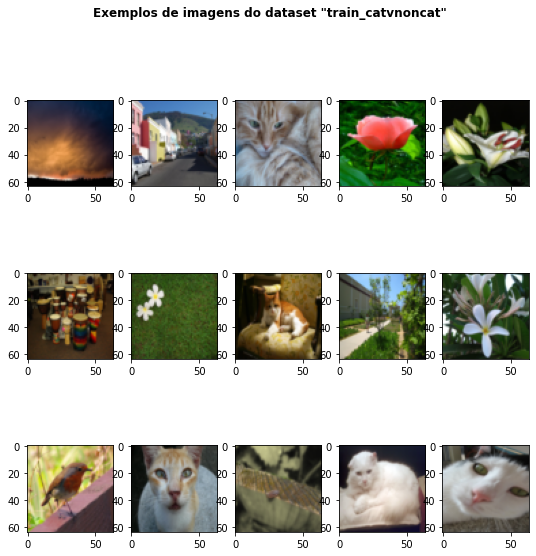

In [129]:
# Plot some of the example images
print('\n\nVisualização de algumas imagens do dataset:')
n_rows = 3
n_cols = 5

f, axarr = plt.subplots(n_rows, n_cols, figsize = (9,9))
idx = 0

for i in range(n_rows):
    for j in range(n_cols):
        axarr[i,j].imshow(X_train[idx])
        idx += 1
plt.suptitle('Exemplos de imagens do dataset "train_catvnoncat"', fontweight='bold')

print('Dimensões de cada imagem:', X_train[0].shape)
print(f'Temos {X_train.shape[0]} imagens de treinamento e {X_test.shape[0]} imagens de teste')

In [130]:
# Inspeção das dimensões dos datasets
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(209, 64, 64, 3) (209,) (50, 64, 64, 3) (50,)


### 3.2.2 Criação de Rede Neural MLP para processamento de imagens

Diferentemente de uma Rede Neural Convolucional, uma MLP requer que os dados de imagens sejam pré-processandos antes de inseri-los na rede neural. Segundo Géron (2019), visto que uma MLP possuem camadas compostas por uma longa linha de neurônio torna-se necessário achatar as imagens em 1D antes de inseri-las na rede neural.

**Linearização dos dados das imagens**

Uma primeira etapa do pré-processamento é converter cada matriz de imagem (64 x 64 x 3) em um array de (com 64*64*3 = 12288 dimensões), que será inserido na rede neural como uma única feature.

In [131]:
# Linearização para uso na MLP
X_trainMLP = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
X_testMLP = X_test.reshape(X_test.shape[0], -1).astype(np.float32)

In [132]:
# Inspeção das dimensões
print(X_trainMLP.shape, X_testMLP.shape)

(209, 12288) (50, 12288)


**Normalização das características**

In [133]:
norm_MLP = StandardScaler()

X_trainMLP_norm = norm_MLP.fit_transform(X_trainMLP)
X_testMLP_norm = norm_MLP.transform(X_testMLP)

**Conversão dos dados em tensores**

In [134]:
X_trainMLP = Variable(Tensor(X_trainMLP_norm).float())
y_trainMLP = Variable(Tensor(y_train).long())

X_testMLP = Variable(Tensor(X_testMLP_norm).float())
y_testMLP = Variable(Tensor(y_test).long())

**Criação da Rede Neural Artificial MLP**

In [135]:
# Criação da Rede Neural Artificial MLP (rede completamente conectada)
class FcNet(torch.nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()

        self.fc1 = torch.nn.Linear(12288, 100)    # 100 neurônios na camada oculta 
        self.fc2 = torch.nn.Linear(100, 2)        # 2 neurônios na camada de saída
        self.output = torch.nn.Softmax(dim=1)     # Softmax activation function
        """
        torch.nn.Linear() : Applies a linear transformation to the incoming data: y = xA^T + b
        torch.nn.Softmax() : Applies the Softmax function to an n-dimensional input Tensor rescaling them so that 
        the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.
        """
        
    def forward(self, X):
        X = F.relu(self.fc1(X))                   # Função de ativação para a camada oculta
        X = F.relu(self.fc2(X))                   # Função de ativação para a camada de saida
        X = self.output(X)                        # output linear
        """
        F.relu : F.relu is the Rectified Linear Unit activation function
        """

        return X

In [136]:
# Criação da rede neural
model = FcNet()

# Inspeção da arquitetura da rede
print(model)

FcNet(
  (fc1): Linear(in_features=12288, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [137]:
# Parâmetros baseados em algoritmos ou funções
criterion = torch.nn.CrossEntropyLoss()                      # Entropia cruzada como função de custo
    """
    cross entropy loss is adequate for classification problems
    """

optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)  # Configuração do otimizador utilizado
    """
    SGD é utilizado para representar todas as versões do GD
    """

NUM_EPOCHS = 1000                                            # número de épocas

**Treinamento da Rede Neural MLP**

In [138]:
# loop to train the neural net
for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()                # clear gradients => valores do otimizador zerados
    out = model(X_trainMLP)              # model() representa a própria rede neural criada => predição da rede neural
    loss = criterion(out, y_trainMLP)    # cálculo da função de custo (aplicada à função de entropia cruzada)
    loss.backward()                      # backpropagation, compute gradients
    optimizer.step()                     # apply gradients (atualização dos parâmetros) => otimização dos hiperparâmetros
    
    if epoch % 100 == 0:
        print('At epoch %d the loss is %f' % (epoch, loss.data.item()))

At epoch 0 the loss is 0.692275
At epoch 100 the loss is 0.628847
At epoch 200 the loss is 0.596830
At epoch 300 the loss is 0.571276
At epoch 400 the loss is 0.550978
At epoch 500 the loss is 0.534223
At epoch 600 the loss is 0.519666
At epoch 700 the loss is 0.507402
At epoch 800 the loss is 0.496342
At epoch 900 the loss is 0.486682


**Aplicação e avaliação da Rede Neural MLP**

In [139]:
# Predições nos dados de teste
predict_out = model(X_testMLP)

    """
    Cada predição é composto por um par (predição para cada classe)
    """

# Returns the maximum value of all elements in the input tensor
_, predict_y = torch.max(predict_out, 1)

In [140]:
# Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_testMLP.data, predict_y.data))

# Relatório de avaliação da classificação
print('-' * 60, end='\n\n')
print('Relatório de avaliação da classificação')
print(classification_report(y_testMLP.data, predict_y.data,
                            zero_division=0))

Matriz de confusão
[[16  1]
 [19 14]]
------------------------------------------------------------

Relatório de avaliação da classificação
              precision    recall  f1-score   support

           0       0.46      0.94      0.62        17
           1       0.93      0.42      0.58        33

    accuracy                           0.60        50
   macro avg       0.70      0.68      0.60        50
weighted avg       0.77      0.60      0.59        50



Os resultados acima mostram que o modelo obteve 60% de acurácia e 62% de F1-score para classe positiva (0) e 58% de F1-score para a classe negativa (1), métricas inferiores às metricas dos modelos vistos anteriormente. Algumas possíveis explicações para este resultado:

* Necessidade de linearização das imagens, visto que a MLP não consegue processar imagens em 2D ou 3D.

* Escolha manual dos hiperparâmetros (anteriormente foi possível ver que modelos que utilizam parâmetros sintonizados obtiveram melhores métricas de avaliação).

* Utilização de um dataset pequeno.

**Verificação dos exemplos (selecionados e aleatório)**

Não há um gato na imagem


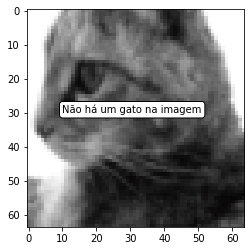

In [141]:
# Imagem analisada
idx = 23

# Análise do resultado
if predict_y[idx] == 1:
    analise = 'Há um gato na imagem'
else:
    analise = 'Não há um gato na imagem'

# Geração do gráfico
plt.imshow(X_test[idx])
plt.annotate(analise, (10,30),
             bbox=dict(boxstyle="round", fc="w"))
  
print(analise)

Não há um gato na imagem


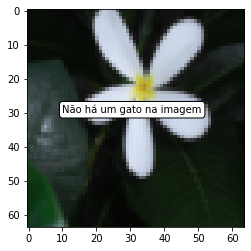

In [142]:
# Imagem analisada
idx = 39

# Análise do resultado
if predict_y[idx] == 1:
    analise = 'Há um gato na imagem'
else:
    analise = 'Não há um gato na imagem'

# Geração do gráfico
plt.imshow(X_test[idx])
plt.annotate(analise, (10,30),
             bbox=dict(boxstyle="round", fc="w"))

print(analise)

Não há um gato na imagem


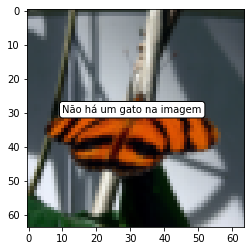

In [143]:
# Imagem analisada
idx = np.random.randint(0,50)

# Análise do resultado
if predict_y[idx] == 1:
    analise = 'Há um gato na imagem'
else:
    analise = 'Não há um gato na imagem'

# Geração do gráfico
plt.imshow(X_test[idx])
plt.annotate(analise, (10,30),
             bbox=dict(boxstyle="round", fc="w"))

print(analise)

### 3.2.3. Criação da Rede Neural Convolucional

**Objetivos**:

* Treinar modelos de redes neurais artificiais para classificar imagens.

* Treinar dois modelos utilizando o `PyTorch`: (i) uma rede completamente conectada de uma única camada oculta e com uma camada de saída e 2 unidades com softmax; (ii) uma rede convolucional.

* Selecionar os hiperparâmentros e arquitetura de redes (em ambos os casos).

* Apresentar os detalhes acerca do desempenho (acurácia) encontrado em cada um dos casos.

**Leitura e tratamento dos dados**

Antes de prosseguir com o treinamento da CNN é preciso adaptar/customizar os dados obtidos por meio da biblioteca `h5py`, a fim de possibilitar que o `DataLoader` consiga fazer uma leitura correta dos dados no `PyTorch`. Essa etpa é realizada por meio de uma classe abstrata do `PyTorch` chamada `torch.utils.data.Dataset`.

In [144]:
# Criação de uma classe baseada na classe Dataset do PyTorch
class HDF5Dataset(Dataset):                           # HDF5 Dataset (dataset gerado por meio da biblioteca h5py)

    def __init__(self, h5_path, x_key, y_key):
        self.x_key = x_key
        self.y_key = y_key
        self.dataset = h5py.File(h5_path, 'r')
        self.length = self.dataset[self.y_key].shape[0]
        self.transform = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        """
        A função "__init__" é executada uma vez ao instanciar o objeto Dataset.
        Inicialização do diretório que contém as imagens, o arquivo de anotações e ambas as transformações. 
        """

    def __getitem__(self, index): #to enable indexing
        numpy_image = self.dataset[self.x_key][index, :]

        # transform to PIL image
        PIL_image = Image.fromarray(np.uint8(numpy_image)).convert('RGB')   # assume your data is uint8 rgb
        image = self.transform(PIL_image)                                   # transformation here
            # torchvision PIL transformations accepts one image as input

        label = self.dataset[self.y_key][index]
        label = torch.tensor(label)
        
        #print('%d: %s' % (index, label))

        return (image, label)
        """
        A função "__getitem__" carrega e retorna uma amostra do dataset no índice "index" fornecido. 
        Com base no índice, ele identifica a localização da imagem no disco, converte-a em um tensor,
        recupera o rótulo correspondente a partir dos dados HDF5, chama as funções de transformação sobre eles (se aplicável)
        e retorna a imagem do tensor e rótulo correspondente em uma tupla. 
        """

    def __len__(self):
        return self.length
        """
        A função "__len__" retorna o número de amostras no dataset
        """

Segundo o tutorial do `PyTorch`, o `Dataset` recupera as características e os rótulos de uma amostra a cada vez. Além disso, é desejável, durante o treinamento de um modelo, passar as amostras em "minibatches", reorganizar os dados a cada época para reduzir o overfitting do modelo e usar o multiprocessamento do Python para acelerar a recuperação de dados. A utilização do iterável `DataLoader` permite ques complexidade seja abstraída em uma API.

In [145]:
# DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(train_set, batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=2)
    return(train_loader)

In [146]:
# Importação dos dados
train_set = HDF5Dataset('dados/train_catvnoncat.h5', 'train_set_x', 'train_set_y')
test_set = HDF5Dataset('dados/test_catvnoncat.h5', 'test_set_x', 'test_set_y')

In [147]:
# Importação das classes para visualização do teste
test_file = h5py.File('dados/test_catvnoncat.h5', 'r')
classes = np.array(test_file['list_classes'][:])

**Divisão do conjunto de treinamento em subconjuntos de treino (80%) e de validação (20%)**

In [148]:
# Definição dos tamanhos dos subconjuntos baseado no conjunto original
NUM_OBS = 209              # número de observações no conjunto de treinamento original
NUM_TEST = 50              # número de observações no conjunto de teste

TREINO = int(NUM_OBS*0.8)  # número de observações no subconjunto de treino (80% do nº de observações do conjunto original)
VALIDA = 209-TREINO        # Número de observações no subconjunto de validação (20% do nº de observações do conjunto original)
TESTE = NUM_TEST           # Número de observações no conjunto de teste

A classe `torch.utils.data.SubsetRandomSampler` do `PyTorch` amostra os elementos aleatoriamente para uma dada lista de índices, sem reposição.

In [149]:
# Training, validation and testing samplers
n_training_samples = TREINO                 # subconjunto de treino 
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

n_val_samples = VALIDA                      # subconjunto de validação
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

n_test_samples = TESTE                      # conjunto de teste
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

"class `torch.utils.data.DataLoader` combines a dataset and a sampler, and provides an iterable over the given dataset."

In [150]:
# Test and validation loaders have constant batch sizes, so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

**Criação da Rede Neural Convolucional**

In [151]:
# classe com representação em lote da rede neural convolucional
class SimpleCNN(torch.nn.Module):
    
    # Our batch shape for input x is (3, 64, 64)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Definição da camada de convolução (Input channels = 3, output channels = 18)
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)  
        """
        torch.nn.Conv2d() : Applies a 2D convolution over an input signal composed of several input planes.
        kernel_size=3 : aplicação de uma matriz de filtro 3x3
        stride=1 : o filtro é aplicado de 1 em 1 etapa sobre a camada de entrada
        padding=1 : criação de uma borda externa de 1x1 para aplicação do kernel
        """

        # Definição da camada de pooling baseada em valores máximos (realização da operação de pooling)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        """
        torch.nn.MaxPool2d () : Applies a 2D max pooling over an input signal composed of several input planes.
        kernel_size=2 : aplicação de uma matriz de filtro 2x2
        stride=2 : o filtro é aplicado de 2 em 2 etapas sobre a camada de entrada
        
        As redes neurais convolucionais usam camadas de pool que são posicionadas imediatamente após a declaração da CNN. 
        Ele recebe a entrada do usuário como um mapa de características que sai de redes convolucionais e prepara um mapa de 
        características condensadas. O agrupamento de camadas ajuda na criação de camadas com neurônios das camadas anteriores.
        """

        # Definição das camadas lineares (linearização dos valores recebidos da operação de pooling)
        self.fc1 = torch.nn.Linear(18 * 32 * 32, 64)    # 1st fully connected layer 
            # 18432 input features, 64 output features
        self.fc2 = torch.nn.Linear(64, 2)               # 2nd fully connected layer
            # 64 input features, 2 output features for 2 defined classes
        """
        torch.nn.Linear() : Applies a linear transformation to the incoming data: y = xA^T + b
        """
     
    # Cálculo da ativação das primeiras alterações no tamanho da convolução 
    def forward(self, x):
        x = F.relu(self.conv1(x))        # ativação da camada de convolução
        x = self.pool(x)                 # ativação da camada de pooling
        x = x.view(-1, 18 * 32 * 32)     # Mudança do tamanho da divisão
        x = F.relu(self.fc1(x))          # ativação da 1ª camada linear
        x = self.fc2(x)                  # ativação da 2ª camada linear
        return(x)

In [152]:
# Função para definição da função de custos e otimizador
def createLossAndOptimizer(net, learning_rate=0.001):
    # Loss function
    loss = torch.nn.CrossEntropyLoss()                          
    """
    torch.nn.CrossEntropy() : This criterion combines LogSoftmax and NLLLoss in one single class.
    Entropia cruzada : indicada para problemas de classificação
    """
    
    # Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)  
    """
    torch.optim.Adam() : Implements Adam algorithm.
    Algoritmo Adam : baseado em um método de otimização estocástica.
    """

    return(loss, optimizer)

**Treinamento da Rede Neural Convolucional**

A função abaixo (`treinaNet`) realiza o treinamento e a validação da Rede Neural Convolucional para cada época. Ao final da execução é possível observar a evolução do processo de otimização e a pontuação da função de custo (verifica se a evolução do treinamento está levando a uma diferença entre treino e validação que indique sobreajuste, subajuste ou evolução dentro do esperado que permita uma melhor generalização do modelo).

In [153]:
# Função para treinamento da rede neural convolucional
def trainNet(net, batch_size, n_epochs, learning_rate):
    
    # Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    # Get training data
    train_loader = get_train_loader(train_set, batch_size)
    n_batches = len(train_loader)
    
    # Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    # Time for printing
    training_start_time = time.time()
        
    # Loop for n_epochs (loop global aplicado para cada época definida para o treinamento)
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        start_time = time.time()
        total_train_loss = 0
        
        # 1º loop interno (treinamento para cada época)
        for i, data in enumerate(train_loader, 0):

            # Get inputs
            inputs, labels = data
            
            # Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            # Set the parameter gradients to zero
            optimizer.zero_grad()
            
            # Forward pass, backward pass, optimize
            outputs = net(inputs)

            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss_size.data
            total_train_loss += loss_size.data

            print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch+1, 
                    int(100 * (i+1) / n_batches), 
                    running_loss, 
                    time.time() - start_time))
            #Reset running loss and time
            running_loss = 0.0
            start_time = time.time()
        
        # 2º loop interno (validação do modelo para determinada época)
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            # Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            # Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [154]:
# Criação do modelo baseado na classe SimpleCNN
CNN = SimpleCNN()

# Treinamento do modelo
trainNet(CNN, batch_size=32, n_epochs=50, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 50
learning_rate= 0.001
Epoch 1, 16% 	 train_loss: 0.75 took: 0.33s
Epoch 1, 33% 	 train_loss: 1.79 took: 0.07s
Epoch 1, 50% 	 train_loss: 0.52 took: 0.06s
Epoch 1, 66% 	 train_loss: 0.68 took: 0.07s
Epoch 1, 83% 	 train_loss: 0.76 took: 0.06s
Epoch 1, 100% 	 train_loss: 0.70 took: 0.03s
Validation loss = 0.64
Epoch 2, 16% 	 train_loss: 0.61 took: 0.25s
Epoch 2, 33% 	 train_loss: 0.65 took: 0.06s
Epoch 2, 50% 	 train_loss: 0.52 took: 0.06s
Epoch 2, 66% 	 train_loss: 0.66 took: 0.06s
Epoch 2, 83% 	 train_loss: 0.65 took: 0.06s
Epoch 2, 100% 	 train_loss: 0.40 took: 0.02s
Validation loss = 0.58
Epoch 3, 16% 	 train_loss: 0.66 took: 0.27s
Epoch 3, 33% 	 train_loss: 0.55 took: 0.06s
Epoch 3, 50% 	 train_loss: 0.50 took: 0.06s
Epoch 3, 66% 	 train_loss: 0.64 took: 0.05s
Epoch 3, 83% 	 train_loss: 0.53 took: 0.06s
Epoch 3, 100% 	 train_loss: 0.75 took: 0.02s
Validation loss = 0.57
Epoch 4, 16% 	 train_loss: 0.54 took: 0.25s
Epoch 4, 33% 	 tr

Pelo output acima é possível inferir que, na média, "validation loss" encontra-se superior ao "train loss". Contudo, esta visualização não é muito clara. A partir destes resultados é possível traçar um gráfico semelhante ao das curvas de aprendizado vistas anteriormente. Claro que não é possível designar o gráfico abaixo como um gráfico de curvas de aprendizado, mas é possível inferir algum *insight* (mesmo que embrionário). 

Assim, pelo gráfico abaixo é possível observar uma tendência ascendente da curva de "validation loss" e uma tendência descendente da curva de "train loss", indicando um provável problema de *overfitting*.

<img src="https://github.com/cristianegea/PPCIC/blob/main/Aprendizado%20de%20Máquinas/Trabalho%203/img/img5.png?raw=true" width="80%"/>

**Teste e avaliação da Rede Neural Convolucional**

In [155]:
# Função para visualização da imagem
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

tensor([1, 0, 0, 1])


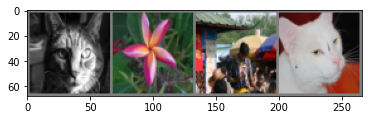

GroundTruth:  b'cat' b'non-cat' b'non-cat' b'cat'


In [156]:
# Carga das imagens de teste e visualização das classes originais
dataiter = iter(test_loader)
images, labels = dataiter.next()

print(labels)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [157]:
# Execução do modelo
outputs = CNN(images)
print(outputs)

tensor([[-0.2873,  0.2471],
        [ 6.0124, -5.9492],
        [ 1.4556, -1.8721],
        [-0.2873,  0.2471]], grad_fn=<AddmmBackward>)


In [158]:
# Transformação das saídas na classificação da identificação de gatos
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  b'cat' b'non-cat' b'non-cat' b'cat'


In [159]:
# Conferência rápida das predições
predicted

tensor([1, 0, 0, 1])

Comparando com as observações originais, é possível observar que o modelo previu corretamente as imagens. 

**Avaliação do modelo treinado**

In [160]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        print(labels)
        # calculate outputs by running images through the network
        outputs = CNN(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(test_set),
    100 * correct / total))

tensor([1, 1, 0, 1])
tensor([1, 1, 1, 1])
tensor([1, 0, 1, 0])
tensor([1, 0, 1, 0])
tensor([0, 1, 1, 0])
tensor([1, 1, 1, 0])
tensor([1, 1, 1, 1])
tensor([1, 1, 0, 1])
tensor([0, 1, 0, 1])
tensor([1, 0, 1, 1])
tensor([1, 0, 0, 1])
tensor([1, 0, 1, 0])
tensor([1, 0])
Accuracy of the network on the 50 test images: 68 %


Enquanto que a Rede Neural MLP obteve 60% de acurácia para tratamento de imagens, a Rede Neural Convolucional (CNN) obteve 68%. Esse resultado corrobora o fato de que a CNN é mais adequada para tratamento de imagens. Contudo, acredita-se que este desempenho pode ser melhorado se for realizada a sintonização dos hiperparâmetros e em um dataset maior.

# Referências

**Livros**

* Sebastian Raschka & Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, Scikit-Learn, and TensorFlow. Editora: Packt - 2ª Edição.

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. Editora: O'Reilly - 2ª Edição.

* Francesco Ricci, Lior Rokach & Bracha Shapira (2015). Recommender Systems Handbook. Editora: Springer - 2ª edição.

* John Hearty (2016). Advanced Machine Learning with Python: Solve challenging data science problems by mastering cutting-edge machine learning techniques in Python. Editora: Packt Publishing.

**Páginas Web**

* [Variáveis Dummy: o que é? Quando usar? E como usar?](https://medium.com/data-hackers/variáveis-dummy-o-que-é-quando-usar-e-como-usar-78de66cfcca9#:~:text=Variáveis%20dummy%20são%20variáveis%20binárias,com%20duas%20ou%20mais%20categorias)

* [Introduction to recommender systems](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada)

* [PyTorch - Rede Neural Convolucional](https://pt.it-brain.online/tutorial/pytorch/pytorch_convolutional_neural_network/)

* [PyTorch Tutorials](https://pytorch.org/tutorials/)

* [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

* [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-1/)

* [Convolutional Neural Network with PyTorch](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_convolutional_neuralnetwork/)

* [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

* [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

* [A Beginners Guide to Skorch – With Code To Implement Neural Network](https://analyticsindiamag.com/a-beginners-guide-to-skorch-with-code-to-implement-neural-network/)

* [skorch.classifier](https://skorch.readthedocs.io/en/latest/classifier.html)

* [Automate Kaggle model training with Skorch and W&B](https://wandb.ai/cayush/uncategorized/reports/Automate-Kaggle-model-training-with-Skorch-and-W-B--Vmlldzo4NTQ1NQ)